<a href="https://colab.research.google.com/github/YuliiaSuprun/COMP540/blob/main/Local_Scoring_on_MUFAC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import linear_model, model_selection
from sklearn.metrics import make_scorer, accuracy_score

import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset, dataset, random_split

import torchvision
from torchvision import datasets, models, transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.models import resnet18
import torchvision.transforms.functional as TF
import torch.nn.functional as F

import copy

from torch.autograd import Variable
import time
import pdb
import math
import shutil
from tqdm import tqdm
from tqdm.notebook import tqdm
from typing import Dict, List, Callable

import random
import glob
from PIL import Image
from IPython.display import display
import warnings

warnings.filterwarnings('ignore')

# Check if GPU is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Using device: cuda


# **Load the MUFAC (Machine Unlearning for Facial Age Classifier) Dataset**
In this section, I'll load a sample dataset:
* based on the "Family Relationship Dataset" from [AI Hub](https://www.aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=realm&dataSetSn=528).
* The dataset contains a total of 900 households and 13,068 individuals (Korean "human face" images).
* This dataset consists of 8 age group classes.The last part of the filename, such as "a1", indicates the "age group."
* In this dataset, all faces are cropped to a resolution of 128 X 128 pixels, although some of the original images have been high resolution.
* Each image filename indicates which family (household) number it belongs to.

We split this dataset into 3 groups:
* **Training dataset**: (F0001 ~ F0299) folders have 10,025 images.
* **Test dataset**: (F0801 ~ F0850) folders have 1,539 images.
* **Unseen dataset**: (F0851 ~ F0900) folders have 1,504 images.

In [ ]:
%%capture
!wget https://postechackr-my.sharepoint.com/:u:/g/personal/dongbinna_postech_ac_kr/EbMhBPnmIb5MutZvGicPKggBWKm5hLs0iwKfGW7_TwQIKg?download=1 -O custom_korean_family_dataset_resolution_128.zip
!unzip custom_korean_family_dataset_resolution_128.zip -d ./custom_korean_family_dataset_resolution_128

In [ ]:
class FamilyAgeDataset(torch.utils.data.Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

    def __len__(self):
        return len(self.meta_data)

    def __getitem__(self, idx):
        # Get the row corresponding to the index
        row = self.meta_data.iloc[idx]

        # Extract image_path and age_class
        image_path = row['image_path']
        age_class = row['age_class']

        # The rest of your code for processing the image and label
        img = Image.open(os.path.join(self.image_directory, image_path)).convert("RGB")
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
# Transformations
train_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.ToTensor()
])

val_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

In [ ]:
# Load Data
train_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./custom_korean_family_dataset_resolution_128/train_images"

val_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "./custom_korean_family_dataset_resolution_128/val_images"

test_meta_data_path = "./custom_korean_family_dataset_resolution_128/custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./custom_korean_family_dataset_resolution_128/test_images"

train_dataset = FamilyAgeDataset(train_meta_data, train_image_directory, train_transform)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

val_dataset = FamilyAgeDataset(val_meta_data, val_image_directory, val_transform)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

test_dataset = FamilyAgeDataset(test_meta_data, test_image_directory, val_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [ ]:
# Mapping from label indices to age groups
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

def show_images(images, labels, nrow=6, save_path=None):
    n_images = len(images)
    nrows = n_images // nrow + (n_images % nrow > 0)

    fig, axs = plt.subplots(nrows, nrow, figsize=(14.5, 2.3 * nrows), frameon=False)
    axs = axs.flatten() if n_images > 1 else [axs]

    for idx, (img, label) in enumerate(zip(images, labels)):
        ax = axs[idx]
        img_np = img.numpy().transpose((1, 2, 0))
        ax.imshow(img_np)
        ax.axis('off')

        age_group = label_to_age[label.item()]
        ax.text(5, 5, age_group, color='white', fontsize=13,  ha='left', va='top',
                bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.1'))

    plt.tight_layout(pad=0)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

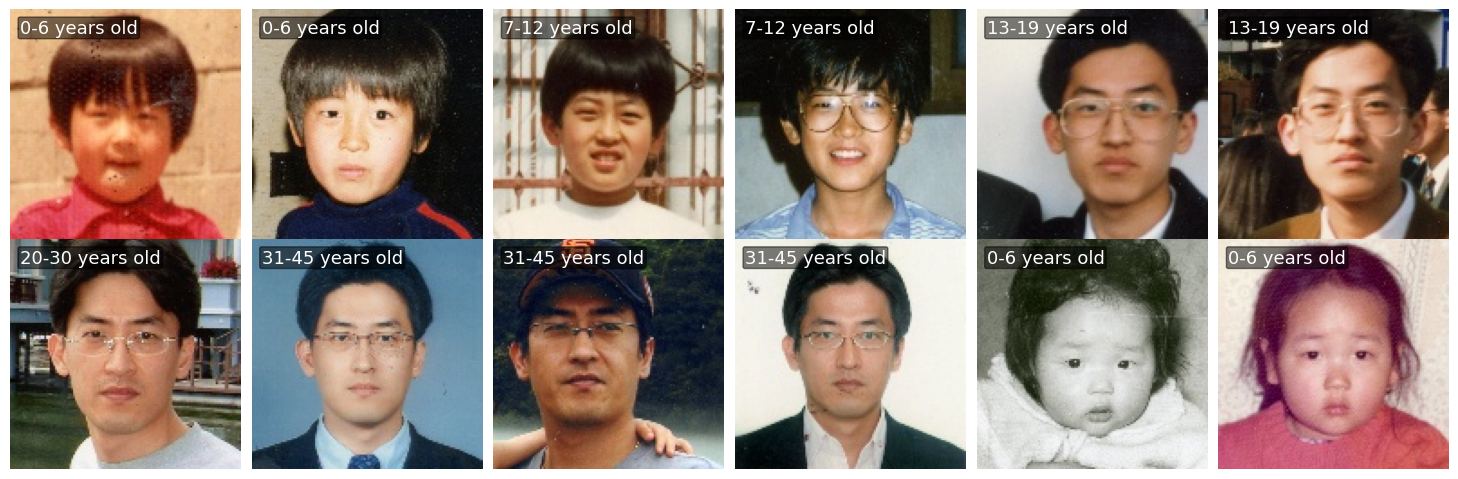

In [ ]:
# Example usage
iterator = iter(val_loader)
imgs, labels = next(iterator)

# Display a subset of images from the batch
show_images(imgs[:12], labels[:12], nrow=6)

# **Split training dataset into forget and retain sets**
* In the NeurIPS Competition setting, when performing machine unlearning, training is done with 'retain' and 'forget', so augmentation can be applied. However, it should never be applied during evaluation.
* We divide training dataset into a retain dataset and a forget dataset.



In [ ]:
# Random seed for reproducibility
torch.manual_seed(42)

# Size of the forget set as a fraction of the total training set
forget_fraction = 0.02  # for example, 2% of the dataset

# Total number of samples in the training set
total_train_samples = len(train_dataset)

# Number of samples to forget
num_forget = int(total_train_samples * forget_fraction)

# Randomly select indices for the forget set
forget_indices = torch.randperm(total_train_samples)[:num_forget]

# Create a boolean mask for the retain set
retain_mask = torch.ones(total_train_samples, dtype=torch.bool)
retain_mask[forget_indices] = False

# Indices for the retain set
retain_indices = torch.arange(total_train_samples)[retain_mask]

# Create the forget and retain subsets
forget_set = Subset(train_dataset, forget_indices.numpy())
retain_set = Subset(train_dataset, retain_indices.numpy())

# Create DataLoaders for the forget and retain sets
forget_loader = DataLoader(forget_set, batch_size=64, shuffle=True)
retain_loader = DataLoader(retain_set, batch_size=64, shuffle=True)

# Retrieve meta data.
forget_meta_data = train_meta_data.iloc[forget_indices]
retain_meta_data = train_meta_data.iloc[retain_indices]

In [ ]:
print('Train dataset size:', len(train_dataset))
print('Test dataset size:', len(val_dataset))
print('Forget dataset size:', len(forget_set))
print('Retain dataset size:', len(retain_set))
print('Unseen dataset size:', len(test_dataset))

Train dataset size: 10025
Test dataset size: 1539
Forget dataset size: 200
Retain dataset size: 9825
Unseen dataset size: 1504


In [ ]:
# Extract image paths directly from the meta_data of each dataset
train_image_paths = train_meta_data['image_path'].tolist()
val_image_paths = val_meta_data['image_path'].tolist()
forget_image_paths = forget_meta_data['image_path'].tolist()
retain_image_paths = retain_meta_data['image_path'].tolist()
test_image_paths = test_meta_data['image_path'].tolist()

# Checking for overlaps
overlap_dict = {
    'train_val': len(set(train_image_paths) & set(val_image_paths)),
    'train_forget': len(set(train_image_paths) & set(forget_image_paths)),
    'train_retain': len(set(train_image_paths) & set(retain_image_paths)),
    'train_test': len(set(train_image_paths) & set(test_image_paths)),
    'val_forget': len(set(val_image_paths) & set(forget_image_paths)),
    'val_retain': len(set(val_image_paths) & set(retain_image_paths)),
    'val_test': len(set(val_image_paths) & set(test_image_paths)),
    'forget_retain': len(set(forget_image_paths) & set(retain_image_paths)),
    'forget_test': len(set(forget_image_paths) & set(test_image_paths)),
    'retain_test': len(set(retain_image_paths) & set(test_image_paths))
}

overlap_dict


{'train_val': 0,
 'train_forget': 200,
 'train_retain': 9825,
 'train_test': 0,
 'val_forget': 0,
 'val_retain': 0,
 'val_test': 0,
 'forget_retain': 0,
 'forget_test': 0,
 'retain_test': 0}

In [ ]:
from collections import Counter

def compute_class_weights_from_loader(data_loader, num_classes, device='cuda'):
    """Compute class weights from a DataLoader."""
    class_counts = Counter()

    for inputs, targets in data_loader:
        class_counts.update(targets.tolist())

    # Convert counts to weights
    class_weights = [1.0 / class_counts[i] if i in class_counts else 0.0 for i in range(num_classes)]

    # Normalize weights so that they sum to num_classes
    total = sum(class_weights)
    normalized_weights = [weight * num_classes / total for weight in class_weights]
    # normalized_weights = [weight / total for weight in class_weights]

    return torch.tensor(normalized_weights, dtype=torch.float32).to(device)

In [ ]:
num_classes = 8
retain_class_weights = compute_class_weights_from_loader(retain_loader, num_classes, DEVICE)
forget_class_weights = compute_class_weights_from_loader(forget_loader, num_classes, DEVICE)

# **Code for Testing and Evaluation**
This is a great resource: [link text](https://www.kaggle.com/code/mgorinova/machine-unlearning-evaluation-on-cifar-10)

In [ ]:
def accuracy(net, loader, DEVICE='cuda'):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total

In [ ]:
def compute_outputs(net, loader):
    """Auxiliary function to compute the logits for all datapoints.
    Does not shuffle the data, regardless of the loader.
    """

    # Make sure loader does not shuffle the data
    if isinstance(loader.sampler, torch.utils.data.sampler.RandomSampler):
        loader = DataLoader(
            loader.dataset,
            batch_size=loader.batch_size,
            shuffle=False,
            num_workers=loader.num_workers)

    all_outputs = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs).detach().cpu().numpy() # (batch_size, num_classes)

        all_outputs.append(logits)

    return np.concatenate(all_outputs) # (len(loader.dataset), num_classes)

In [ ]:
def false_positive_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false positive rate (FPR)."""
    fp = np.sum(np.logical_and((y_pred == 1), (y_true == 0)))
    n = np.sum(y_true == 0)
    return fp / n

def false_negative_rate(y_true: np.ndarray, y_pred: np.ndarray) -> float:
    """Computes the false negative rate (FNR)."""
    fn = np.sum(np.logical_and((y_pred == 0), (y_true == 1)))
    p = np.sum(y_true == 1)
    return fn / p

# The SCORING dictionary is used by sklearn's `cross_validate` function so that
# we record the FPR and FNR metrics of interest when doing cross validation
SCORING = {
    'false_positive_rate': make_scorer(false_positive_rate),
    'false_negative_rate': make_scorer(false_negative_rate)
}

In [ ]:
def cross_entropy_f(x):
    # To ensure this function doesn't fail due to nans, find
    # all-nan rows in x and substitude them with all-zeros.
    x[np.all(np.isnan(x), axis=-1)] = np.zeros(x.shape[-1])

    pred = torch.tensor(np.nanargmax(x, axis = -1))
    x = torch.tensor(x)

    fn = nn.CrossEntropyLoss(reduction="none")

    return fn(x, pred).numpy()

In [ ]:
def logistic_regression_attack(
        outputs_U, outputs_R, n_splits=2, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      fpr, fnr : float * float
    """
    assert len(outputs_U) == len(outputs_R)

    samples = np.concatenate((outputs_R, outputs_U)).reshape((-1, 1))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    scores =  model_selection.cross_validate(
        attack_model, samples, labels, cv=cv, scoring=SCORING)

    fpr = np.mean(scores["test_false_positive_rate"])
    fnr = np.mean(scores["test_false_negative_rate"])

    return fpr, fnr


def best_threshold_attack(
        outputs_U: np.ndarray,
        outputs_R: np.ndarray,
        random_state: int = 0
    ) -> tuple[list[float], list[float]]:
    """Computes FPRs and FNRs for an attack that simply splits into
    predicted positives and predited negatives based on any possible
    single threshold.

    Args:
      outputs_U: numpy array of shape (N)
      outputs_R: numpy array of shape (N)
    Returns:
      fpr, fnr : list[float] * list[float]
    """
    assert len(outputs_U) == len(outputs_R)

    samples = np.concatenate((outputs_R, outputs_U))
    labels = np.array([0] * len(outputs_R) + [1] * len(outputs_U))

    N = len(outputs_U)

    fprs, fnrs = [], []
    for thresh in sorted(list(samples.squeeze())):
        ypred = (samples > thresh).astype("int")
        fprs.append(false_positive_rate(labels, ypred))
        fnrs.append(false_negative_rate(labels, ypred))

    return fprs, fnrs

In [ ]:
def compute_epsilon_s(fpr: list[float], fnr: list[float], delta: float) -> float:
    """Computes the privacy degree (epsilon) of a particular forget set example,
    given the FPRs and FNRs resulting from various attacks.

    The smaller epsilon is, the better the unlearning is.

    Args:
      fpr: list[float] of length m = num attacks. The FPRs for a particular example.
      fnr: list[float] of length m = num attacks. The FNRs for a particular example.
      delta: float
    Returns:
      epsilon: float corresponding to the privacy degree of the particular example.
    """
    assert len(fpr) == len(fnr)

    per_attack_epsilon = [0.]
    for fpr_i, fnr_i in zip(fpr, fnr):
        if fpr_i == 0 and fnr_i == 0:
            per_attack_epsilon.append(np.inf)
        elif fpr_i == 0 or fnr_i == 0:
            pass # discard attack
        else:
            with np.errstate(invalid='ignore'):
                epsilon1 = np.log(1. - delta - fpr_i) - np.log(fnr_i)
                epsilon2 = np.log(1. - delta - fnr_i) - np.log(fpr_i)
            if np.isnan(epsilon1) and np.isnan(epsilon2):
                per_attack_epsilon.append(np.inf)
            else:
                per_attack_epsilon.append(np.nanmax([epsilon1, epsilon2]))

    return np.nanmax(per_attack_epsilon)


def bin_index_fn(
        epsilons: np.ndarray,
        bin_width: float = 0.5,
        B: int = 13
        ) -> np.ndarray:
    """The bin index function."""
    bins = np.arange(0, B) * bin_width
    return np.digitize(epsilons, bins)


def compute_forgetting_quality(epsilons: np.ndarray) -> float:
    """Computes the forgetting quality given the privacy degrees
    of the forget set examples.
    """
    ns = bin_index_fn(epsilons)
    hs = 2. / 2 ** ns
    return np.mean(hs)

In [ ]:
def forgetting_quality(
        outputs_U: np.ndarray, # (N, S)
        outputs_R: np.ndarray, # (N, S)
        attacks: list[Callable] = [logistic_regression_attack],
        delta: float = 0.01
    ):
    """
    Both `outputs_U` and `outputs_R` are of numpy arrays of ndim 2:
    * 1st dimension coresponds to the number of samples obtained from the
      distribution of each model (N=512 in the case of the competition's leaderboard)
    * 2nd dimension corresponds to the number of samples in the forget set (S).
    """

    # N = number of model samples
    # S = number of forget samples
    N, S = outputs_U.shape

    assert outputs_U.shape == outputs_R.shape, \
        "unlearn and retrain outputs need to be of the same shape"

    epsilons = []
    pbar = tqdm(range(S))
    for sample_id in pbar:
        pbar.set_description("Computing F...")

        sample_fprs, sample_fnrs = [], []

        for attack in attacks:
            uls = outputs_U[:, sample_id]
            rls = outputs_R[:, sample_id]

            fpr, fnr = attack(uls, rls)

            if isinstance(fpr, list):
                sample_fprs.extend(fpr)
                sample_fnrs.extend(fnr)
            else:
                sample_fprs.append(fpr)
                sample_fnrs.append(fnr)

        sample_epsilon = compute_epsilon_s(sample_fprs, sample_fnrs, delta=delta)
        epsilons.append(sample_epsilon)

    return compute_forgetting_quality(np.array(epsilons))

In [ ]:
def score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader,
                               original_model, rt_model, unlearning: Callable,
                               n: int = 10, delta: float = 0.01, f: Callable = cross_entropy_f,
                               attacks: list[Callable] = [best_threshold_attack, logistic_regression_attack]) -> dict:

    # n=512 in the case of unlearn and n=1 in the
    # case of retrain, since we are only provided with one retrained model here

    outputs_U = []
    retain_accuracy = []
    test_accuracy = []
    forget_accuracy = []

    pbar = tqdm(range(n))
    for i in pbar:
        # unlearned model
        u_model = copy.deepcopy(original_model)
        # Execute the unlearing routine. This might take a few minutes.
        # If run on colab, be sure to be running it on  an instance with GPUs

        pbar.set_description(f"Unlearning...")
        u_model = unlearning(u_model, retain_loader, forget_loader, val_loader)

        outputs_Ui = compute_outputs(u_model, forget_loader)
        # The shape of outputs_Ui is (len(forget_loader.dataset), 10)
        # which for every datapoint is being cast to a scalar using the funtion f
        outputs_U.append( f(outputs_Ui) )

        pbar.set_description(f"Computing retain accuracy...")
        retain_accuracy.append(accuracy(u_model, retain_loader))

        pbar.set_description(f"Computing test accuracy...")
        test_accuracy.append(accuracy(u_model, test_loader))

        pbar.set_description(f"Computing forget accuracy...")
        forget_accuracy.append(accuracy(u_model, forget_loader))


    outputs_U = np.array(outputs_U) # (n, len(forget_loader.dataset))

    assert outputs_U.shape == (n, len(forget_loader.dataset)),\
        "Wrong shape for outputs_U. Should be (num_model_samples, num_forget_datapoints)."

    RAR = accuracy(rt_model, retain_loader)
    TAR = accuracy(rt_model, test_loader)
    FAR = accuracy(rt_model, forget_loader)

    RAU = np.mean(retain_accuracy)
    TAU = np.mean(test_accuracy)
    FAU = np.mean(forget_accuracy)

    RA_ratio = RAU / RAR
    TA_ratio = TAU / TAR

    # need to fake this a little because we only have one retrain model
    scale = np.std(outputs_U) / 10.
    outputs_Ri = compute_outputs(rt_model, forget_loader) #(len(forget_loader.dataset), 10)
    outputs_Ri = np.expand_dims(outputs_Ri, axis=0)
    outputs_Ri = np.random.normal(
        loc=outputs_Ri, scale=scale, size=(n, *outputs_Ri.shape[-2:]))

    outputs_R = np.array([ f( oRi ) for oRi in outputs_Ri ])

    np.save("outputs_U.npy", outputs_U)
    np.save("outputs_R.npy", outputs_R)

    f = forgetting_quality(
        outputs_U,
        outputs_R,
        attacks=attacks,
        delta=delta)

    return {
        "total_score": f * RA_ratio * TA_ratio,
        "F": f,
        "unlearn_retain_accuracy": RAU,
        "unlearn_test_accuracy": TAU,
        "unlearn_forget_accuracy": FAU,
        "retrain_retain_accuracy": RAR,
        "retrain_test_accuracy": TAR,
        "retrain_forget_accuracy": FAR,
        "retrain_outputs": outputs_R,
        "unlearn_outputs": outputs_U
    }

In [ ]:
def compute_losses(net, loader, DEVICE='cuda'):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)

In [ ]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [ ]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

def subsample(large_set, num_samples):
    assert len(large_set) > num_samples
    np.random.shuffle(large_set)
    return large_set[:num_samples]

def perform_mia(model, forget_loader, test_loader, DEVICE='cuda', n_splits=10):
    set_seed(42)

    forget_losses = compute_losses(model, forget_loader, DEVICE)
    test_losses = compute_losses(model, test_loader, DEVICE)

    if (len(test_losses) < len(forget_losses)):
        # Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
        forget_losses = subsample(forget_losses, len(test_losses))
    elif (len(test_losses) > len(forget_losses)):
        # Since we have more test losses than forget losses, sub-sample them, to have a class-balanced dataset.
        test_losses = subsample(test_losses, len(forget_losses))

    # make sure we have a balanced dataset for the MIA
    assert len(test_losses) == len(forget_losses)

    samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
    labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

    mia_scores = simple_mia(samples_mia, labels_mia, n_splits)
    forgetting_score = abs(0.5 - mia_scores.mean())
    return {'MIA': mia_scores.mean(), 'Forgeting Score': forgetting_score, 'forget_losses': forget_losses, 'test_losses':test_losses}

In [ ]:
def print_metrics(model, retain_loader, forget_loader, test_loader, DEVICE='cuda', model_name="Model"):
    # Performance
    train_acc = accuracy(model, retain_loader, DEVICE)
    test_acc = accuracy(model, test_loader, DEVICE)
    mia_results = perform_mia(model, forget_loader, test_loader, DEVICE)
    mia_score = mia_results['MIA']
    forgetting_score = mia_results['Forgeting Score']
    forget_losses = mia_results['forget_losses']
    test_losses = mia_results['test_losses']
    final_score = (test_acc + (1 - abs(mia_score - 0.5) * 2)) / 2
    print(f"============ Metrics for {model_name} ============")
    print(f'Train Accuracy: {100.0 * train_acc:0.1f}%')
    print(f'Test Accuracy: {100.0 * test_acc:0.1f}%')
    print(f'MIA score: {mia_score:0.4f}')
    print()
    print(f'Final Score: {final_score:0.4f}')
    return mia_score, forget_losses, test_losses, forgetting_score, train_acc, test_acc

In [ ]:
def compare_models(model1, model2, retain_loader, forget_loader, test_loader, DEVICE='cuda', model1_name="Model1", model2_name="Model2"):
    mia_score1, forget_losses1, test_losses1, forgetting_score1, train_acc1, test_acc1 = print_metrics(model1, retain_loader, forget_loader, test_loader, DEVICE, model1_name)
    mia_score2, forget_losses2, test_losses2, forgetting_score2, train_acc2, test_acc2 = print_metrics(model2, retain_loader, forget_loader, test_loader, DEVICE, model2_name)

    # fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    # ax1.set_title(f"{model1_name}\nAttack accuracy: {mia_score1:0.2f}")
    # ax1.hist(test_losses1, density=True, alpha=0.5, bins=50, label="Test set")
    # ax1.hist(forget_losses1, density=True, alpha=0.5, bins=50, label="Forget set")

    # ax2.set_title(
    #     f"{model2_name}.\nAttack accuracy: {mia_score2:0.2f}"
    # )
    # ax2.hist(test_losses2, density=True, alpha=0.5, bins=50, label="Test set")
    # ax2.hist(forget_losses2, density=True, alpha=0.5, bins=50, label="Forget set")

    # ax1.set_xlabel("Loss")
    # ax2.set_xlabel("Loss")
    # ax1.set_ylabel("Frequency")
    # ax1.set_yscale("log")
    # ax2.set_yscale("log")
    # ax1.set_xlim((0, np.max(test_losses1)))
    # ax2.set_xlim((0, np.max(test_losses1)))
    # for ax in (ax1, ax2):
    #     ax.spines["top"].set_visible(False)
    #     ax.spines["right"].set_visible(False)
    # ax1.legend(frameon=False, fontsize=14)
    # plt.show()
    yellow = "#fcc138"
    blue = "#0277e6"
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.set_title(f"{model1_name}\nAttack accuracy: {mia_score1:0.3f}")
    ax1.hist(test_losses1, density=True, alpha=0.6, bins=50, color=yellow, label="Test Set")
    ax1.hist(forget_losses1, density=True, alpha=0.6, bins=50, color=blue, label="Forget Set")

    ax2.set_title(f"{model2_name}\nAttack accuracy: {mia_score2:0.3f}")
    ax2.hist(test_losses2, density=True, alpha=0.6, bins=50, color=yellow, label="Test Set")
    ax2.hist(forget_losses2, density=True, alpha=0.6, bins=50, color=blue, label="Forget Set")

    ax1.set_xlabel("Loss")
    ax2.set_xlabel("Loss")
    ax1.set_ylabel("Frequency")
    ax2.set_ylabel("Frequency")
    ax1.set_yscale("log")
    ax2.set_yscale("log")
    ax1.set_xlim((0, np.max(test_losses1)))
    ax2.set_xlim((0, np.max(test_losses2)))

    for ax in (ax1, ax2):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(axis='x')
        ax.tick_params(axis='y')

    ax1.legend(frameon=False, fontsize=14)
    ax2.legend(frameon=False, fontsize=14)

    plt.show()
    return forgetting_score2, train_acc2, test_acc2

# **Train the Original ResNet18 Model** (can skip this step)

In [ ]:
# Define the Model
num_epochs = 50
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)  # 8 classes for age groups
model = model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-3)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=30):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    best_val_accuracy = 0.0

    for epoch in range(num_epochs):
        # Training Phase
        model.train()
        total_loss = 0.0
        total_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_corrects += torch.sum(preds == labels.data)

        epoch_loss = total_loss / len(train_loader.dataset)
        epoch_acc = total_corrects.double() / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc.cpu())

        # Validation Phase
        model.eval()
        total_loss = 0.0
        total_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                total_loss += loss.item() * inputs.size(0)
                total_corrects += torch.sum(preds == labels.data)

        epoch_loss = total_loss / len(val_loader.dataset)
        epoch_acc = total_corrects.double() / len(val_loader.dataset)
        val_losses.append(epoch_loss)
        val_accuracies.append(epoch_acc.cpu())

        scheduler.step()

        # Check if the validation accuracy of this epoch is the best
        if epoch_acc > best_val_accuracy:
            best_val_accuracy = epoch_acc
            # Save the best model
            torch.save(model.state_dict(), 'my_best_model.pth')
            print(f'Checkpoint saved at epoch {epoch+1} with validation accuracy: {best_val_accuracy:.4f}')

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.4f}')

    return train_losses, train_accuracies, val_losses, val_accuracies

In [ ]:
# Training the model
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Checkpoint saved at epoch 1 with validation accuracy: 0.2398
Epoch [1/50], Train Loss: 1.7114, Train Acc: 0.3280, Val Loss: 1.7826, Val Acc: 0.2398
Epoch [2/50], Train Loss: 1.4536, Train Acc: 0.4125, Val Loss: 2.5961, Val Acc: 0.1839
Checkpoint saved at epoch 3 with validation accuracy: 0.4542
Epoch [3/50], Train Loss: 1.3581, Train Acc: 0.4444, Val Loss: 1.3317, Val Acc: 0.4542
Epoch [4/50], Train Loss: 1.3132, Train Acc: 0.4575, Val Loss: 1.3138, Val Acc: 0.4542
Epoch [5/50], Train Loss: 1.2553, Train Acc: 0.4769, Val Loss: 1.3496, Val Acc: 0.4243
Checkpoint saved at epoch 6 with validation accuracy: 0.4815
Epoch [6/50], Train Loss: 1.2312, Train Acc: 0.4885, Val Loss: 1.2122, Val Acc: 0.4815
Epoch [7/50], Train Loss: 1.1851, Train Acc: 0.4989, Val Loss: 1.4080, Val Acc: 0.4392
Checkpoint saved at epoch 8 with validation accuracy: 0.4893
Epoch [8/50], Train Loss: 1.1706, Train Acc: 0.5178, Val Loss: 1.2550, Val Acc: 0.4893
Epoch [9/50], Train Loss: 1.1510, Train Acc: 0.5172, Val Los

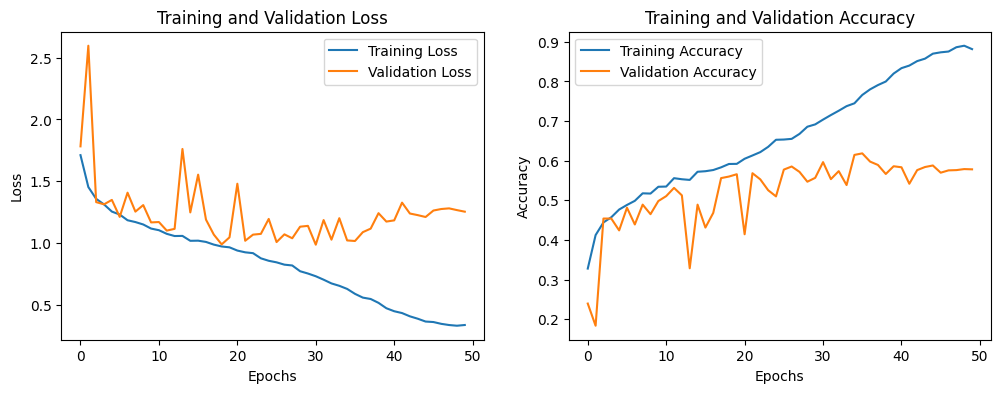

In [ ]:
# Plotting training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot([acc.item() for acc in train_accuracies], label='Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

As we can see, our datasets have no overlap, which is essential for proper Machine Unlearning!

# **Retrain the model from scratch** (can skip this step)
* A model trained on only the retain dataset from scratch, excluding the forget dataset.
* This model can serve as a proxy ground-truth for calculating the potential ground-truth model utility and forgetting score.

In [ ]:
# Define the Model
num_epochs = 50
model = models.resnet18(pretrained=False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 8)  # 8 classes for age groups
model = model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-3)
# optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

In [ ]:
# Retraining the model from scratch
train_losses, train_accuracies, val_losses, val_accuracies = train_model(model, retain_loader, val_loader, criterion, optimizer, scheduler, num_epochs)

Checkpoint saved at epoch 1 with validation accuracy: 0.2495
Epoch [1/50], Train Loss: 1.6705, Train Acc: 0.3454, Val Loss: 1.8981, Val Acc: 0.2495
Epoch [2/50], Train Loss: 1.4304, Train Acc: 0.4186, Val Loss: 1.9572, Val Acc: 0.2378
Checkpoint saved at epoch 3 with validation accuracy: 0.3431
Epoch [3/50], Train Loss: 1.3462, Train Acc: 0.4494, Val Loss: 1.5523, Val Acc: 0.3431
Epoch [4/50], Train Loss: 1.2987, Train Acc: 0.4607, Val Loss: 1.8881, Val Acc: 0.2684
Epoch [5/50], Train Loss: 1.2804, Train Acc: 0.4736, Val Loss: 1.6023, Val Acc: 0.2840
Checkpoint saved at epoch 6 with validation accuracy: 0.4743
Epoch [6/50], Train Loss: 1.2275, Train Acc: 0.4913, Val Loss: 1.2239, Val Acc: 0.4743
Epoch [7/50], Train Loss: 1.1837, Train Acc: 0.5075, Val Loss: 1.3611, Val Acc: 0.4009
Epoch [8/50], Train Loss: 1.1631, Train Acc: 0.5163, Val Loss: 1.4977, Val Acc: 0.3951
Epoch [9/50], Train Loss: 1.1445, Train Acc: 0.5194, Val Loss: 1.3178, Val Acc: 0.4165
Checkpoint saved at epoch 10 with 

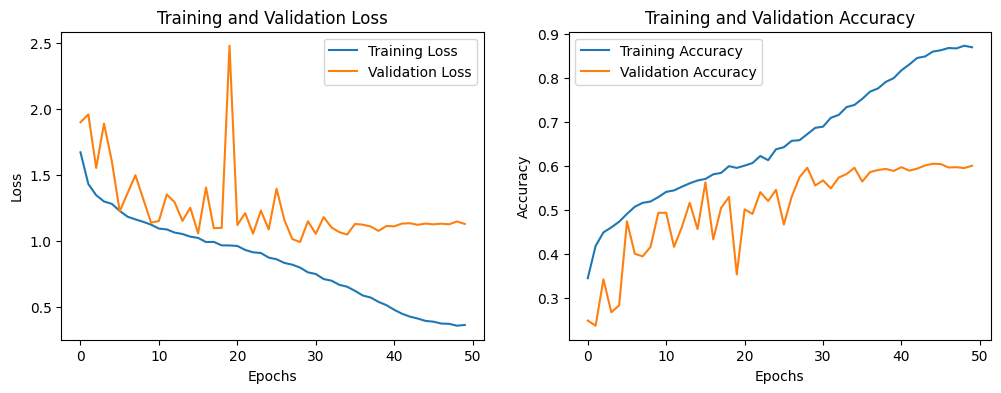

In [ ]:
# Plotting training and validation losses
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting training and validation accuracies
plt.subplot(1, 2, 2)
plt.plot([acc.item() for acc in train_accuracies], label='Training Accuracy')
plt.plot([acc.item() for acc in val_accuracies], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# **Load the Original and Retrained Models**
These are ResNet18 models, trained on the entire training dataset and trained only on retain set.

The checkpoints are located here: https://drive.google.com/drive/folders/1xAjtAv2U5GleNo56XeyN9GFVqz-zRKxx?usp=sharing

Please upload them to this notebook and run the code below.

In [ ]:
# Define the same model architecture
original_model = models.resnet18(pretrained=False)
num_ftrs = original_model.fc.in_features
original_model.fc = nn.Linear(num_ftrs, 8)  # Assuming 8 classes for age groups

# Load the saved model state
model_path = 'my_original_model.pth'
original_model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))

# Move model to the appropriate device
original_model = original_model.to(DEVICE)

In [ ]:
# Define the same model architecture
retrained_model = models.resnet18(pretrained=False)
num_ftrs = retrained_model.fc.in_features
retrained_model.fc = nn.Linear(num_ftrs, 8)  # Assuming 8 classes for age groups

# Load the saved model state
model_path = 'my_retrained_model.pth'
retrained_model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE)))

# Move model to the appropriate device
retrained_model = retrained_model.to(DEVICE)

## Compute accuracy

In [ ]:
print(f"Original model - Train set accuracy: {100.0 * accuracy(original_model, train_loader, DEVICE):0.1f}%")
print(f"Original model - Test set accuracy: {100.0 * accuracy(original_model, test_loader, DEVICE):0.1f}%")

Original model - Train set accuracy: 78.2%
Original model - Test set accuracy: 61.0%


In [ ]:
print(f"Retrained model - Train set accuracy: {100.0 * accuracy(retrained_model, retain_loader, DEVICE):0.1f}%")
print(f"Retrained model - Test set accuracy: {100.0 * accuracy(retrained_model, test_loader, DEVICE):0.1f}%")

Retrained model - Train set accuracy: 86.4%
Retrained model - Test set accuracy: 62.2%


## Compute losses

In [ ]:
original_train_losses = compute_losses(original_model, train_loader, DEVICE)
original_test_losses = compute_losses(original_model, test_loader, DEVICE)
print("original_train_losses: ", original_train_losses)
print("original_test_losses: ", original_test_losses)

original_train_losses:  [0.6337083  0.4515921  0.03910112 ... 0.86943233 0.4462024  0.62827265]
original_test_losses:  [0.05127985 0.03087407 0.14940266 ... 1.5289714  2.1662495  0.77933323]


In [ ]:
retrain_train_losses = compute_losses(retrained_model, train_loader, DEVICE)
retrain_test_losses = compute_losses(retrained_model, test_loader, DEVICE)
print("retrain_train_losses: ", retrain_train_losses)
print("retrain_test_losses: ", retrain_test_losses)

retrain_train_losses:  [0.19921245 0.14107299 0.04623919 ... 0.4137072  0.03123775 0.8623065 ]
retrain_test_losses:  [0.02572145 0.07580651 0.1405922  ... 1.7124538  5.73702    0.87382036]


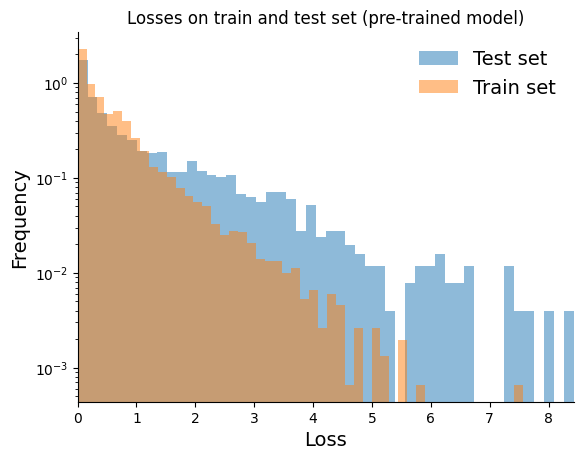

In [ ]:
# plot losses on train and test set
plt.title("Losses on train and test set (pre-trained model)")
plt.hist(original_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
plt.hist(original_train_losses, density=True, alpha=0.5, bins=50, label="Train set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(original_test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
plt.show()

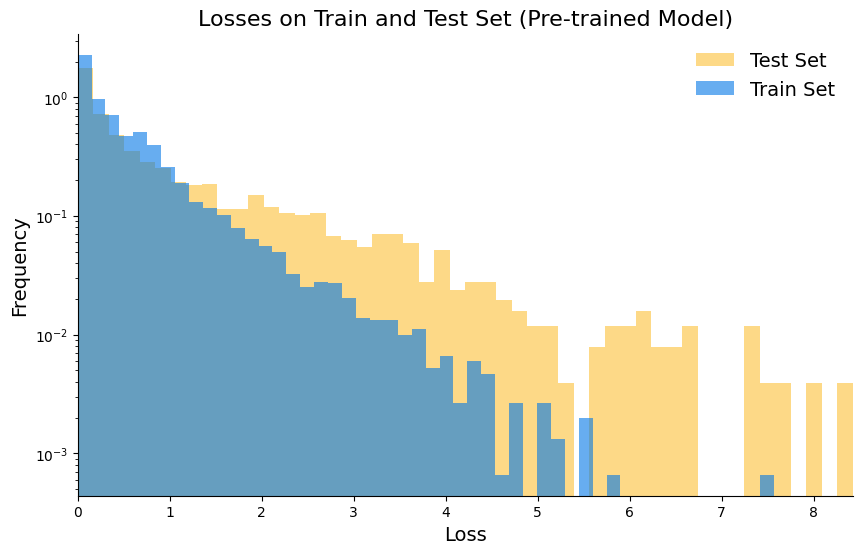

In [ ]:

# More intense (dirty yellow) and intense blue colors
yellow = "#fcc138"
blue = "#0277e6"

# Plot with adjusted colors
plt.figure(figsize=(10, 6))
plt.title("Losses on Train and Test Set (Pre-trained Model)", fontsize=16)
plt.hist(original_test_losses, density=True, alpha=0.6, bins=50, color=yellow, label="Test Set")
plt.hist(original_train_losses, density=True, alpha=0.6, bins=50, color=blue, label="Train Set")
plt.xlabel("Loss", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.xlim((0, np.max(original_test_losses)))
plt.yscale("log")
plt.legend(frameon=False, fontsize=14)

# Customizing the plot to match the poster colors
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.tick_params(axis='x')
ax.tick_params(axis='y')

# Show the plot
plt.show()

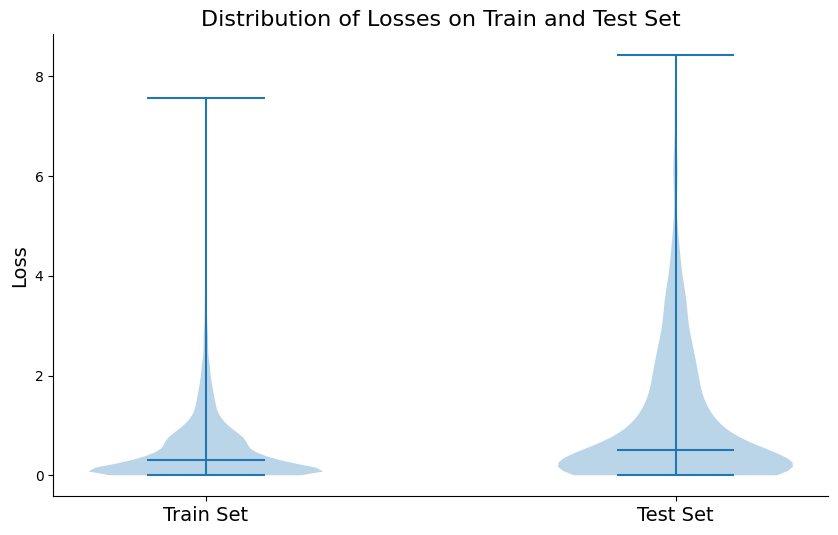

In [ ]:
# Creating a violin plot for the train and test losses

plt.figure(figsize=(10, 6))
plt.title("Distribution of Losses on Train and Test Set", fontsize=16)

# Preparing data for the violin plot
data_to_plot = [original_train_losses, original_test_losses]

# Creating the violin plot
plt.violinplot(data_to_plot, showmeans=False, showmedians=True)
plt.xticks([1, 2], ["Train Set", "Test Set"], fontsize=14)
plt.ylabel("Loss", fontsize=14)

# Customizing the plot
ax = plt.gca()
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)

ax.tick_params(axis='x')
ax.tick_params(axis='y')

plt.show()


## **Compare the original vs retrained-from-scratch models.**

============ Metrics for Original Model ============
Train Accuracy: 78.5%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Retrained-from-scratch Model ============
Train Accuracy: 86.1%
Test Accuracy: 62.1%
MIA score: 0.5150

Final Score: 0.7955


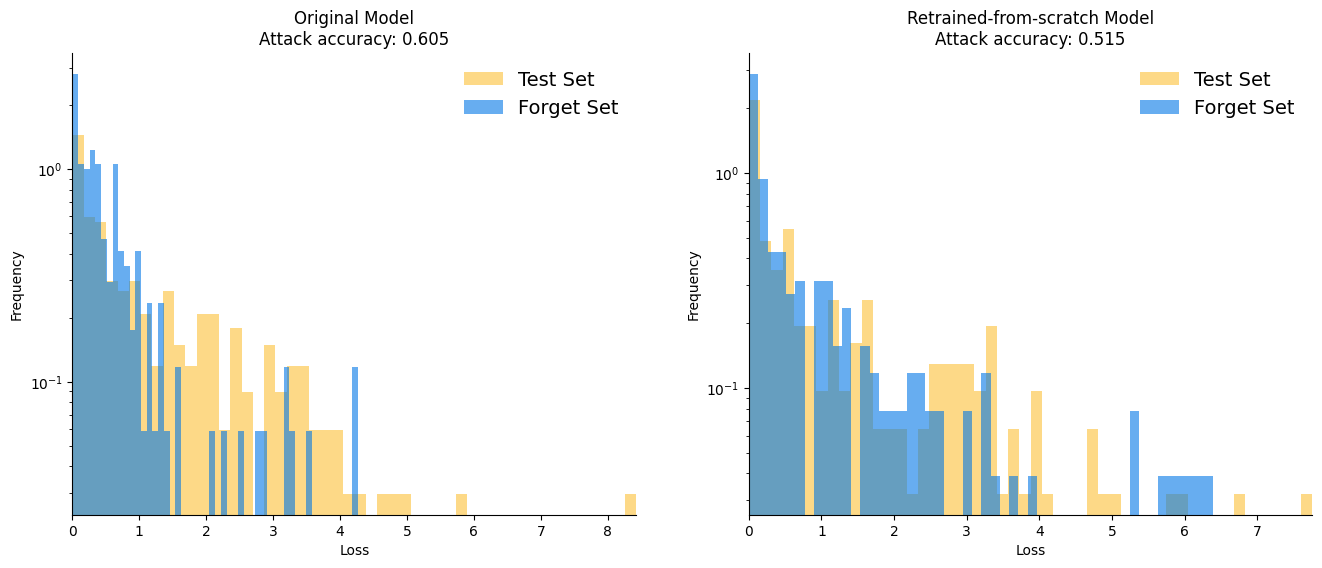

In [ ]:
_, retain_accuracy_retrain, test_accuracy_retrain = compare_models(original_model, retrained_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Retrained-from-scratch Model")

# **Unlearning Approaches**
## **Approach 1: Simple Fine-tuning on the retain set**
* A method where the original model undergoes further training solely on the retain dataset.
* This approach aims to reinforce the model's knowledge of the retain dataset, potentially leading to the forgetting of the previously learned forget dataset.
* On the Kaggle hidden datatset, this approach performs best with the following parameters:
  * num_epochs = 1
  * optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)**bold text**

In [ ]:
def unlearning_finetune(net, retain_loader, forget_loader, val_loader, retain_class_weights=None, DEVICE='cuda'):
    """Unlearning by fine-tuning.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain_loader : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget_loader : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      val_loader : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    epochs = 3

    criterion = nn.CrossEntropyLoss(weight=retain_class_weights)
    optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-1)
    #optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [ ]:
unlearned_model = copy.deepcopy(original_model)
unlearned_model = unlearning_finetune(unlearned_model, retain_loader, forget_loader, val_loader, retain_class_weights, DEVICE)

============ Metrics for Original Model ============
Train Accuracy: 78.0%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.6999
============ Metrics for Unlearned Model by Fine-tuning ============
Train Accuracy: 85.5%
Test Accuracy: 67.0%
MIA score: 0.5600

Final Score: 0.7748


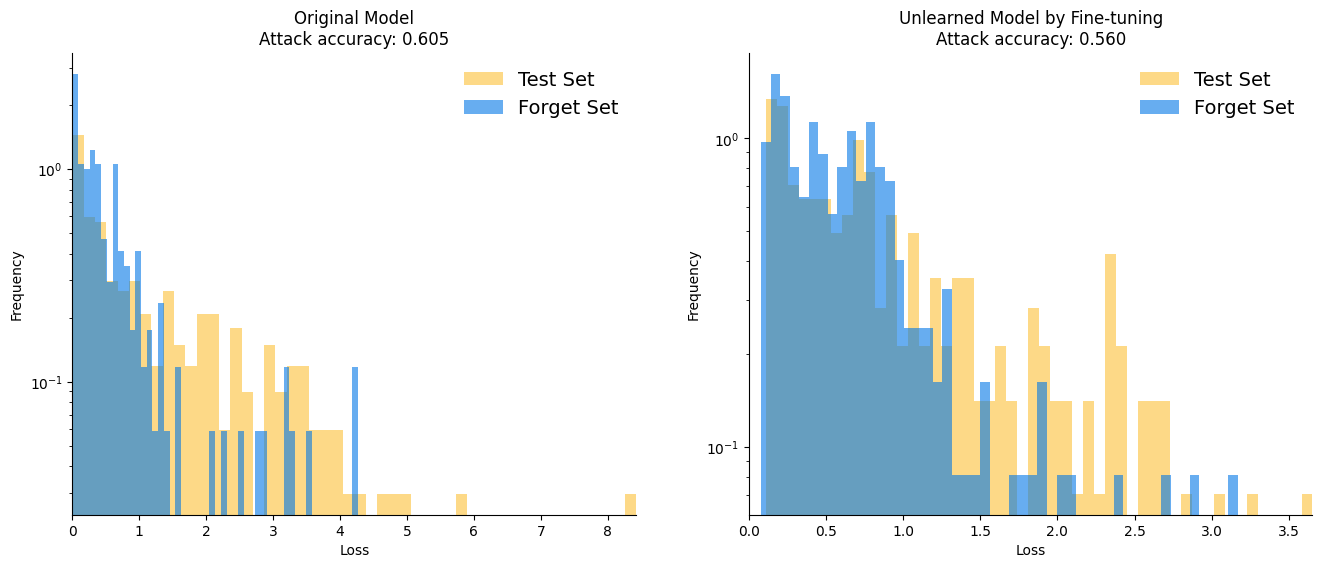

In [ ]:
# optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-1, epochs = 3)
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Fine-tuning")

============ Metrics for Original Model ============
Train Accuracy: 78.2%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.6999
============ Metrics for Unlearned Model by Fine-tuning ============
Train Accuracy: 79.8%
Test Accuracy: 65.9%
MIA score: 0.5575

Final Score: 0.7720


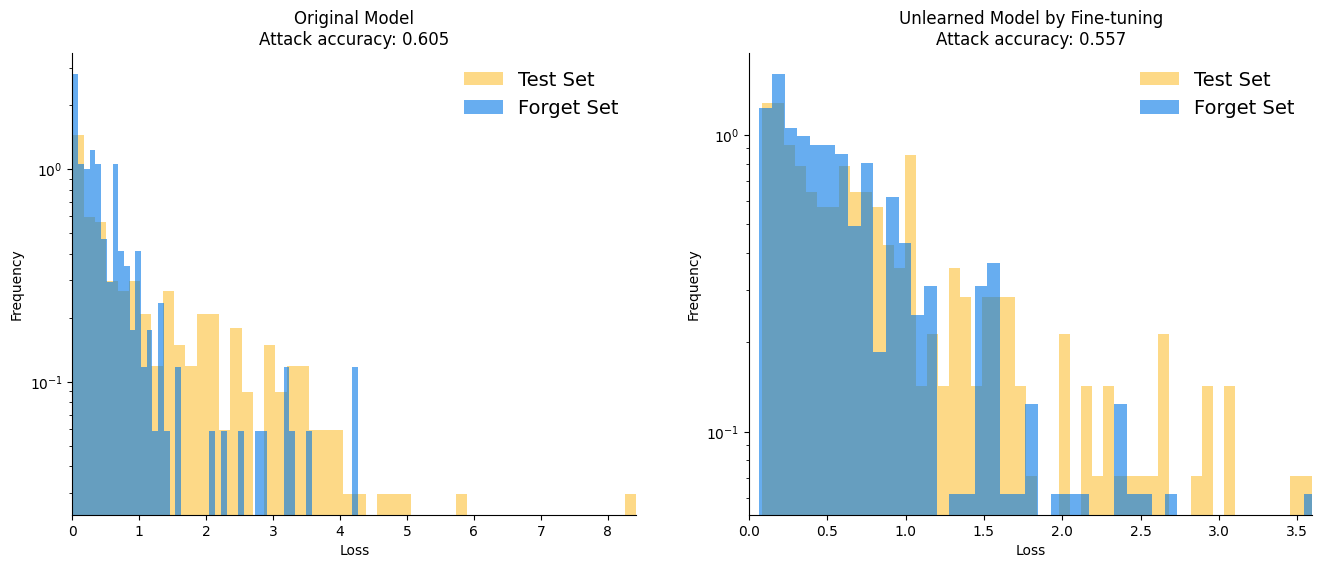

In [ ]:
# optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-1, epochs = 2)
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Fine-tuning")

### **Results for Adam(net.parameters(), lr=0.0001, weight_decay=1e-3) trained for 1 epoch**

Adam(net.parameters(), lr=0.0001, weight_decay=1e-3), trained for 1 epoch, achieved the best **total score of 0.09416**. However, this score is achieved because of improvement in the accuracy and not because the model actually forgot the forget data points.

MIA score of 0.56 is pretty good (the retrained from scratch model achieved a MIA score of 0.52).

============ Metrics for Original Model ============
Train Accuracy: 78.2%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by Fine-tuning ============
Train Accuracy: 80.5%
Test Accuracy: 65.4%
MIA score: 0.5700

Final Score: 0.7571


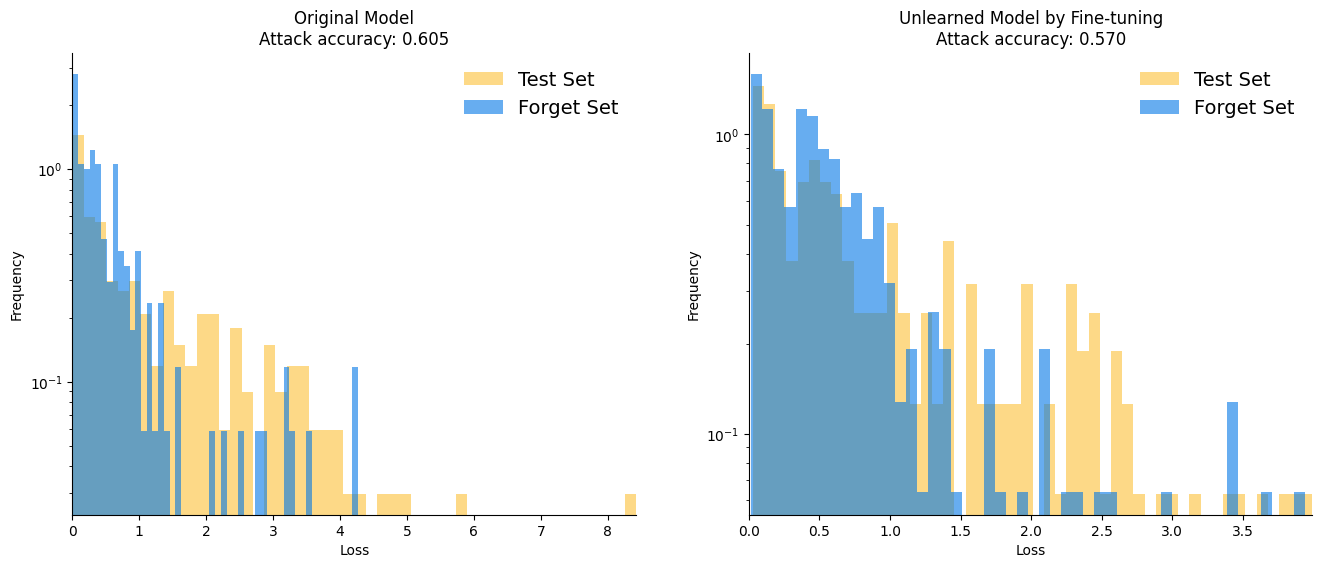

In [ ]:
# optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-1)
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Fine-tuning")

============ Metrics for Original Model ============
Train Accuracy: 78.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by Fine-tuning with weighted Cross-Entropy ============
Train Accuracy: 79.2%
Test Accuracy: 64.3%
MIA score: 0.6100

Final Score: 0.7115


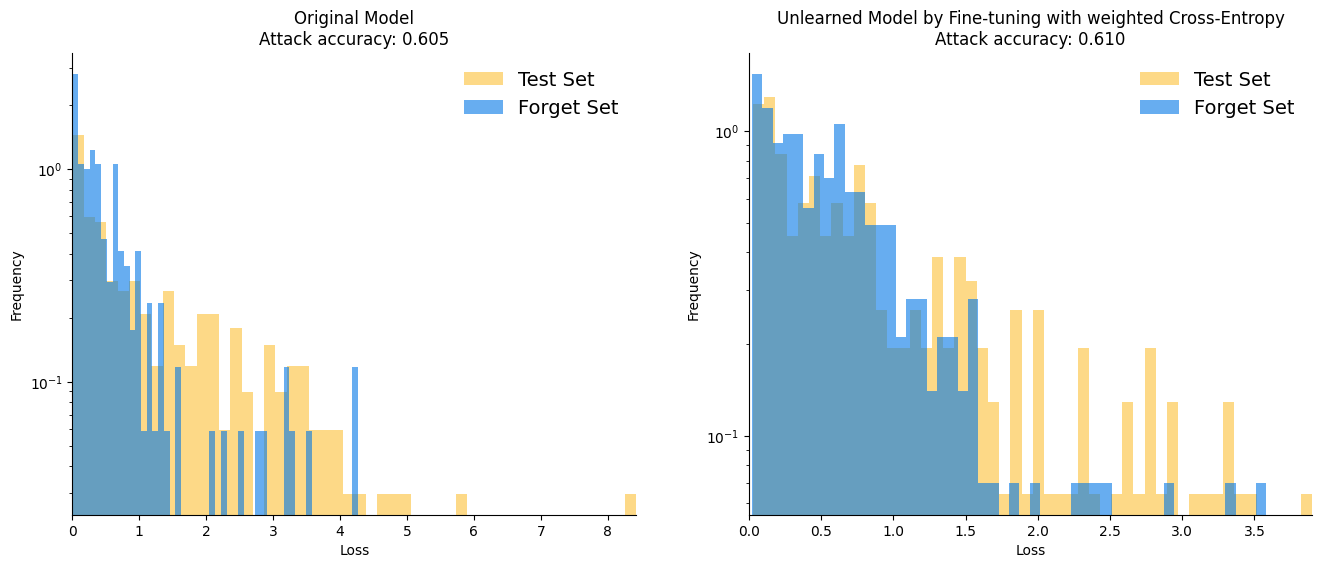

In [ ]:
# optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-1)
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Fine-tuning with weighted Cross-Entropy")

In [ ]:
# optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-3)
ret = score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader, original_model, retrained_model, unlearning_finetune, 10)
ret

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'total_score': 0.02497181620956835,
 'F': 0.0267626953125,
 'unlearn_retain_accuracy': 0.7735267175572519,
 'unlearn_test_accuracy': 0.6448803191489362,
 'unlearn_forget_accuracy': 0.7635000000000001,
 'retrain_retain_accuracy': 0.8608651399491094,
 'retrain_test_accuracy': 0.6210106382978723,
 'retrain_forget_accuracy': 0.705,
 'retrain_outputs': array([[0.01959523, 0.64259398, 0.64492568, ..., 0.78811055, 0.51455781,
         0.82916339],
        [0.02220788, 0.66362118, 0.6232225 , ..., 0.79821576, 0.52298515,
         0.81199833],
        [0.02222984, 0.65308001, 0.62614641, ..., 0.83394996, 0.5235685 ,
         0.85112747],
        ...,
        [0.0215168 , 0.62282665, 0.66742549, ..., 0.8254781 , 0.5031461 ,
         0.84333525],
        [0.02099184, 0.64063171, 0.61690549, ..., 0.80136961, 0.51651014,
         0.85136197],
        [0.02155595, 0.64473055, 0.65540043, ..., 0.81067917, 0.5026202 ,
         0.82489497]]),
 'unlearn_outputs': array([[0.07770101, 0.5473546 , 0.62839

### **Results for Adam(net.parameters(), lr=0.0001, weight_decay=5e-3) trained for 1 epoch**
* increased the weight-decay parameter, which might help with overfitting
* achieved the **total score of 0.07048**.

It's fascinating that such a small change in weight_decay leads to much worse forgetting!

============ Metrics for Original Model ============
Train Accuracy: 78.1%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by Fine-tuning ============
Train Accuracy: 74.5%
Test Accuracy: 65.1%
MIA score: 0.5850

Final Score: 0.7405


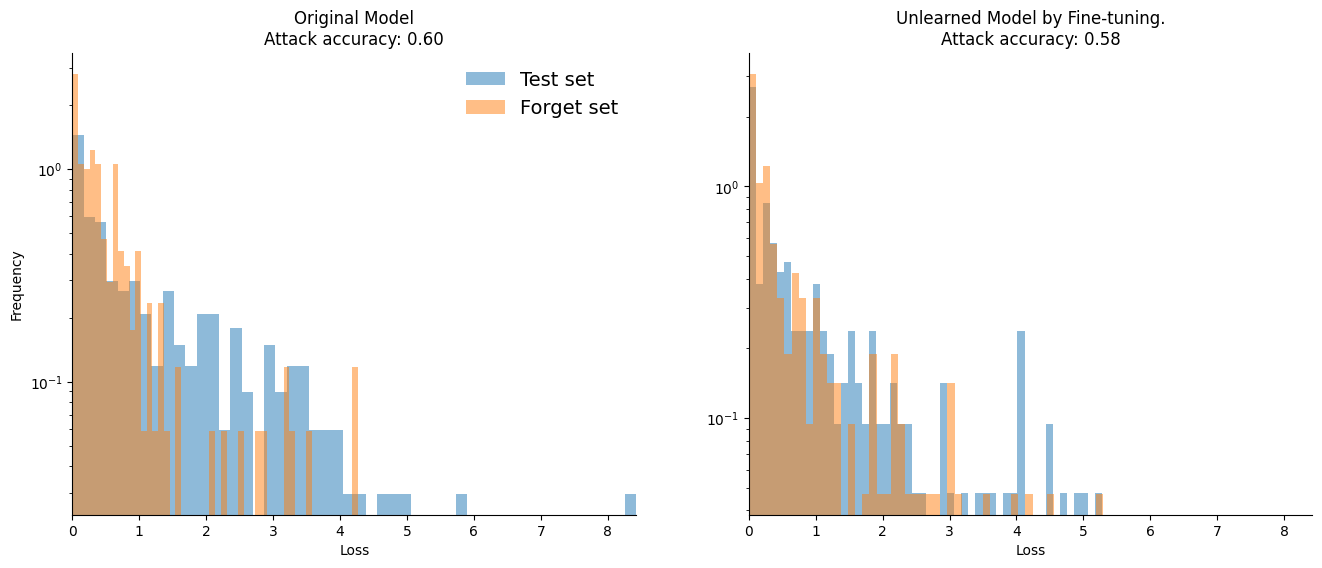

In [ ]:
# optim.Adam(net.parameters(), lr=0.0001, weight_decay=5e-3)
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Fine-tuning")

In [ ]:
# optim.Adam(net.parameters(), lr=0.0001, weight_decay=5e-3)
ret = score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader, original_model, retrained_model, unlearning_finetune, 10)
ret

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'total_score': 0.07048039982100408,
 'F': 0.074522705078125,
 'unlearn_retain_accuracy': 0.7915419847328244,
 'unlearn_test_accuracy': 0.6387632978723404,
 'unlearn_forget_accuracy': 0.7855000000000001,
 'retrain_retain_accuracy': 0.8608651399491094,
 'retrain_test_accuracy': 0.6210106382978723,
 'retrain_forget_accuracy': 0.705,
 'retrain_outputs': array([[0.01979667, 0.64405032, 0.64540054, ..., 0.7910732 , 0.51319101,
         0.83195912],
        [0.02210815, 0.66260784, 0.62621169, ..., 0.80002292, 0.52060774,
         0.81676682],
        [0.02212747, 0.65330457, 0.62879983, ..., 0.8315236 , 0.52112334,
         0.85136347],
        ...,
        [0.02150001, 0.62654668, 0.66523542, ..., 0.82407002, 0.50313727,
         0.8444797 ],
        [0.02103615, 0.64230226, 0.62061094, ..., 0.80280058, 0.51490715,
         0.85156968],
        [0.02153451, 0.64593418, 0.6546407 , ..., 0.81102564, 0.50266838,
         0.82816431]]),
 'unlearn_outputs': array([[0.00919973, 0.5095492 , 0.151

### **Results for Adam(net.parameters(), lr=0.0001, weight_decay=5e-4) trained for 1 epoch**
* considering a previous situation, we decrease the weight-decay parameter now, which might help to improve forgetting.
* achieved the **total score of 0.076102**.

This is still worse than the case, when we use weight_decay=1e-3.
This proves that this method is way too sensitive to hyper-parameters.

============ Metrics for Original Model ============
Train Accuracy: 78.5%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.6999
============ Metrics for Unlearned Model by Fine-tuning ============
Train Accuracy: 75.5%
Test Accuracy: 64.6%
MIA score: 0.6000

Final Score: 0.7228


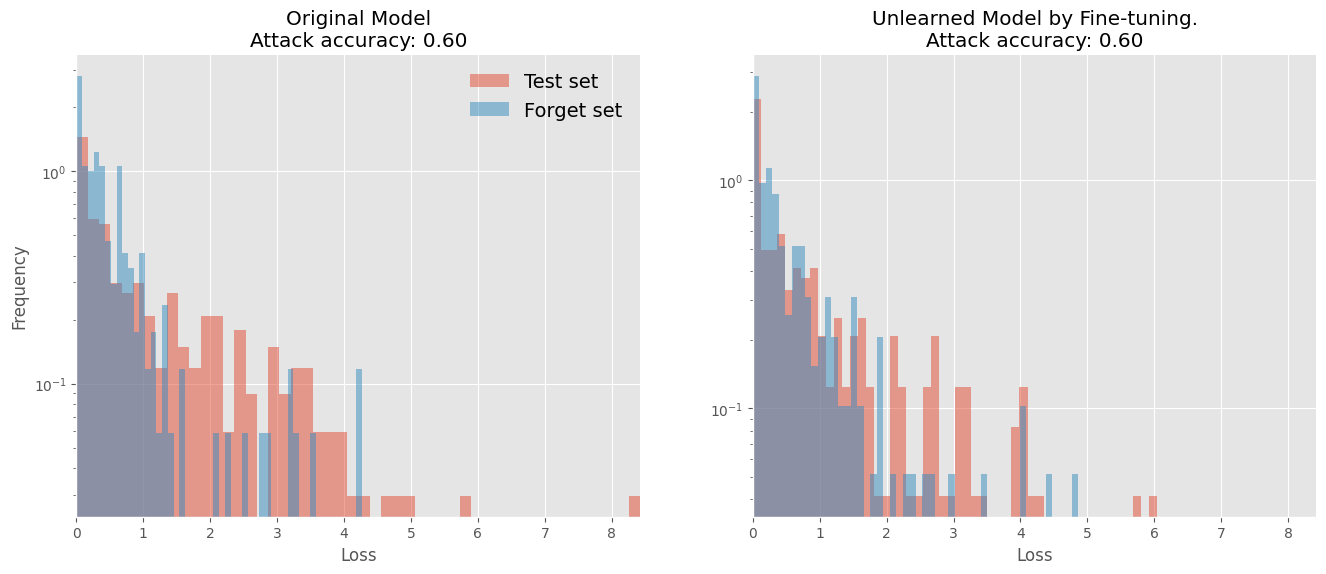

In [ ]:
# optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Fine-tuning")

In [ ]:
# optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
ret = score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader, original_model, retrained_model, unlearning_finetune, 10)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

In [ ]:
ret

{'total_score': 0.06268561231731866,
 'F': 0.076102294921875,
 'unlearn_retain_accuracy': 0.7318066157760814,
 'unlearn_test_accuracy': 0.6064494680851065,
 'unlearn_forget_accuracy': 0.7055,
 'retrain_retain_accuracy': 0.8657506361323155,
 'retrain_test_accuracy': 0.6223404255319149,
 'retrain_forget_accuracy': 0.705,
 'retrain_outputs': array([[0.01840938, 0.6207936 , 0.07668033, ..., 0.07692998, 0.62797092,
         0.67540832],
        [0.01843285, 0.63589117, 0.07669347, ..., 0.07157264, 0.63028195,
         0.6944469 ],
        [0.01740018, 0.63282172, 0.07494442, ..., 0.07777954, 0.59437579,
         0.67999492],
        ...,
        [0.01749171, 0.648725  , 0.07619514, ..., 0.07819061, 0.61997857,
         0.70405868],
        [0.01789064, 0.64229823, 0.08123793, ..., 0.07645468, 0.60563699,
         0.69383609],
        [0.01800599, 0.61885743, 0.08284477, ..., 0.07360213, 0.62204825,
         0.67894819]]),
 'unlearn_outputs': array([[0.36499897, 0.59635824, 0.7103841 , ..., 

### **Results for Adam(net.parameters(), lr=0.00005, weight_decay=5e-3) trained for 1 epoch**

============ Metrics for Original Model ============
Train Accuracy: 78.1%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by Fine-tuning (lr=0.00005, weight_decay=5e-3) ============
Train Accuracy: 81.9%
Test Accuracy: 62.6%
MIA score: 0.6350

Final Score: 0.6778


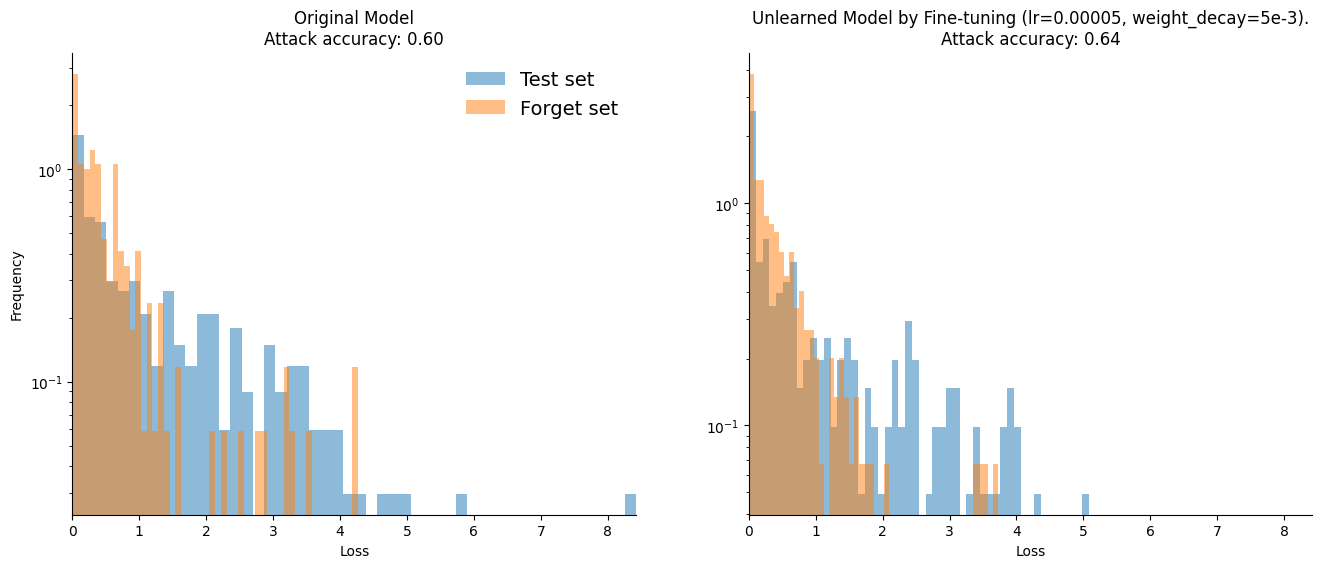

In [ ]:
# optim.Adam(net.parameters(), lr=0.00005, weight_decay=5e-3)
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Fine-tuning (lr=0.00005, weight_decay=5e-3)")

In [ ]:
ret = score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader, original_model, retrained_model, unlearning_finetune, 10)
ret

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'total_score': 0.09949788918857976,
 'F': 0.098590087890625,
 'unlearn_retain_accuracy': 0.820559796437659,
 'unlearn_test_accuracy': 0.6575132978723406,
 'unlearn_forget_accuracy': 0.8229999999999998,
 'retrain_retain_accuracy': 0.8608651399491094,
 'retrain_test_accuracy': 0.6210106382978723,
 'retrain_forget_accuracy': 0.705,
 'retrain_outputs': array([[0.01985457, 0.64446799, 0.64553781, ..., 0.79192103, 0.51280214,
         0.83275781],
        [0.02207972, 0.6623199 , 0.62706903, ..., 0.80053905, 0.51993116,
         0.81813132],
        [0.0220983 , 0.65337032, 0.62956087, ..., 0.83083188, 0.52042736,
         0.85142979],
        ...,
        [0.0214952 , 0.62761395, 0.66461239, ..., 0.82366811, 0.50313553,
         0.84480593],
        [0.02104882, 0.64278192, 0.62167418, ..., 0.80320952, 0.51445114,
         0.85162796],
        [0.02152837, 0.64627973, 0.65442544, ..., 0.81112427, 0.50268316,
         0.82909968]]),
 'unlearn_outputs': array([[0.00965733, 0.22339138, 0.2281

## **Approach 2: Custom Loss Function with Gradient Ascend**

In [ ]:
def advanced_neggrad_unlearning(net, retain_loader, forget_loader, val_loader, retain_class_weights=None, forget_class_weights=None, DEVICE='cuda'):
    """
    Unlearning by Advanced NegGrad with Classification Loss.

    Args:
      model (nn.Module): Pre-trained model to use as base of unlearning.
      retain_loader (DataLoader): DataLoader for the retain set.
      forget_loader (DataLoader): DataLoader for the forget set.
      DEVICE (str): Device to use for computation. Defaults to 'cuda'.

    Returns:
      nn.Module: Updated model after unlearning.
    """
    epochs = 1
    neg_grad_factor=0.1 # Factor for negated gradient impact

    # retain_criterion = nn.CrossEntropyLoss(weight=retain_class_weights)
    # forget_criterion = nn.CrossEntropyLoss(weight=forget_class_weights)
    retain_criterion = nn.CrossEntropyLoss()
    forget_criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=1e-1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    net.train()

    forget_iterator = iter(forget_loader)

    for _ in range(epochs):
        for retain_inputs, retain_targets in retain_loader:
            retain_inputs, retain_targets = retain_inputs.to(DEVICE), retain_targets.to(DEVICE)
            try:
                (forget_inputs, forget_targets) = next(forget_iterator)
            except StopIteration:
                forget_iterator = iter(forget_loader)
                (forget_inputs, forget_targets) = next(forget_iterator)
            forget_inputs, forget_targets = forget_inputs.to(DEVICE), forget_targets.to(DEVICE)
            if forget_inputs.size(0) != retain_inputs.size(0):
                continue

            optimizer.zero_grad()
            retain_outputs = net(retain_inputs)
            forget_outputs = net(forget_inputs)

            retain_loss = retain_criterion(retain_outputs, retain_targets)
            forget_loss = forget_criterion(forget_outputs, forget_targets)

            # Overall loss
            joint_loss = retain_loss - neg_grad_factor*forget_loss

            joint_loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [ ]:
unlearned_model = copy.deepcopy(original_model)
unlearned_model = advanced_neggrad_unlearning(unlearned_model, retain_loader, forget_loader, val_loader, retain_class_weights, forget_class_weights, DEVICE)

============ Metrics for Original Model ============
Train Accuracy: 77.8%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by Advanced NegGrad ============
Train Accuracy: 75.6%
Test Accuracy: 61.9%
MIA score: 0.5100

Final Score: 0.7995


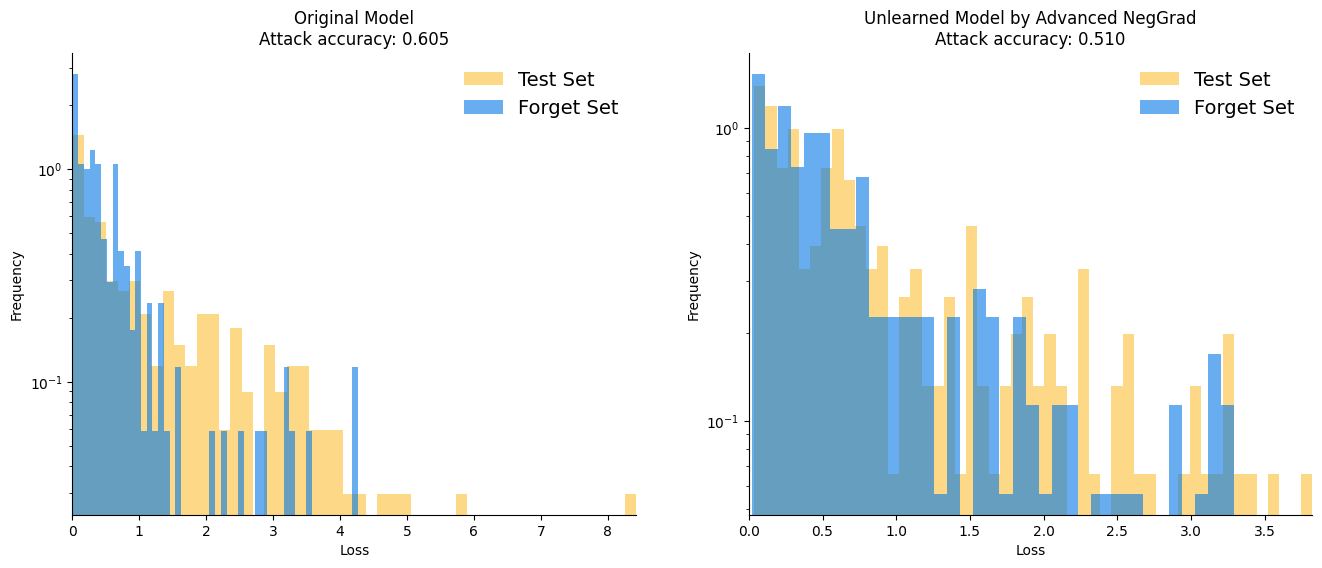

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Advanced NegGrad")

============ Metrics for Original Model ============
Train Accuracy: 78.0%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by Advanced NegGrad and Weighted Cross Entropy ============
Train Accuracy: 64.9%
Test Accuracy: 54.1%
MIA score: 0.5425

Final Score: 0.7278


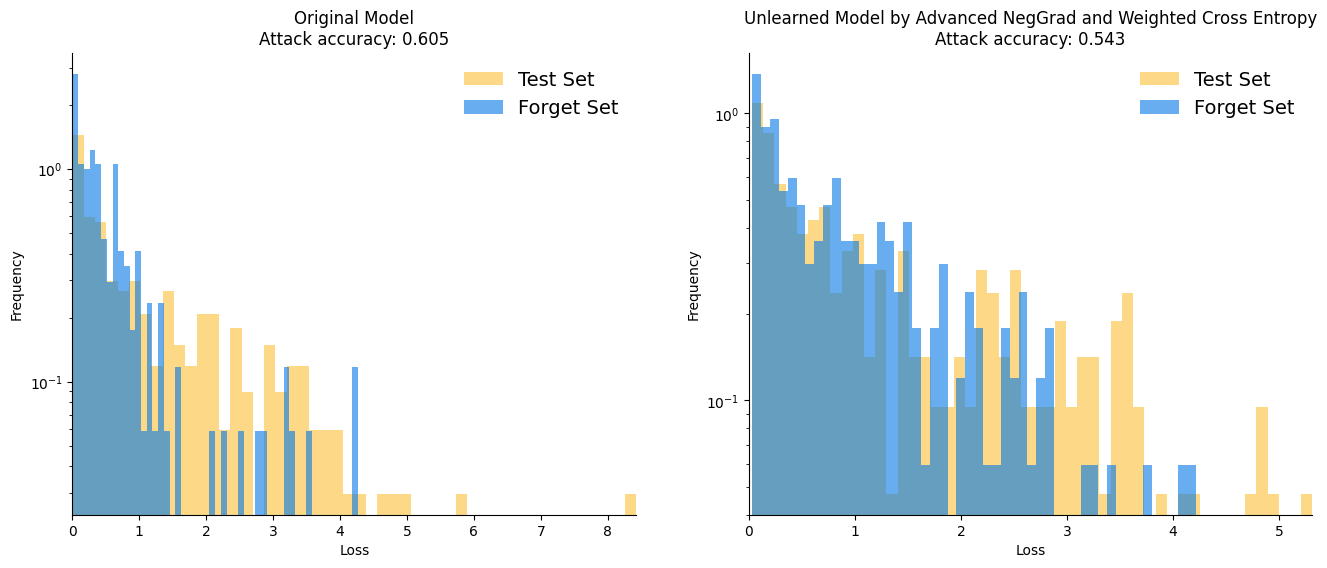

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Advanced NegGrad and Weighted Cross Entropy")

In [ ]:
ret = score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader, original_model, retrained_model, advanced_neggrad_unlearning, 10)
ret

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

{'total_score': 0.033121271741981956,
 'F': 0.036129150390625,
 'unlearn_retain_accuracy': 0.7762442748091603,
 'unlearn_test_accuracy': 0.633909574468085,
 'unlearn_forget_accuracy': 0.6525000000000001,
 'retrain_retain_accuracy': 0.8643256997455471,
 'retrain_test_accuracy': 0.6210106382978723,
 'retrain_forget_accuracy': 0.7,
 'retrain_outputs': array([[0.01515117, 0.50215962, 0.29117418, ..., 0.31610304, 0.28512542,
         0.08485832],
        [0.01723591, 0.51720831, 0.28051763, ..., 0.31596606, 0.28695902,
         0.08481898],
        [0.01724727, 0.51410793, 0.28143956, ..., 0.33208271, 0.29055235,
         0.08641441],
        ...,
        [0.01662727, 0.49062626, 0.3039145 , ..., 0.32621491, 0.27815692,
         0.08798557],
        [0.01643923, 0.50619998, 0.2780779 , ..., 0.31970934, 0.28137516,
         0.08981615],
        [0.01670753, 0.50695756, 0.29718338, ..., 0.32450906, 0.27435103,
         0.08790457]]),
 'unlearn_outputs': array([[0.55448455, 0.52483916, 0.51254

## **Approach 3: Selective Synaptic Dampening (SSD)**



In [ ]:
import random

class ParameterPerturber:
    def __init__(
        self,
        model,
        opt,
        device="cuda" if torch.cuda.is_available() else "cpu",
        parameters=None,
    ):
        self.model = model
        self.opt = opt
        self.device = device
        self.alpha = None
        self.xmin = None

        print(parameters)
        self.lower_bound = parameters["lower_bound"]
        self.exponent = parameters["exponent"]
        self.magnitude_diff = parameters["magnitude_diff"]  # unused
        self.min_layer = parameters["min_layer"]
        self.max_layer = parameters["max_layer"]
        self.forget_threshold = parameters["forget_threshold"]
        self.dampening_constant = parameters["dampening_constant"]
        self.selection_weighting = parameters["selection_weighting"]

    def get_layer_num(self, layer_name: str) -> int:
        layer_id = layer_name.split(".")[1]
        if layer_id.isnumeric():
            return int(layer_id)
        else:
            return -1

    def zerolike_params_dict(self, model: torch.nn) -> Dict[str, torch.Tensor]:
        """
        Taken from: Avalanche: an End-to-End Library for Continual Learning - https://github.com/ContinualAI/avalanche
        Returns a dict like named_parameters(), with zeroed-out parameter valuse
        Parameters:
        model (torch.nn): model to get param dict from
        Returns:
        dict(str,torch.Tensor): dict of zero-like params
        """
        return dict(
            [
                (k, torch.zeros_like(p, device=p.device))
                for k, p in model.named_parameters()
            ]
        )

    def calc_importance(self, dataloader: DataLoader, class_weights=None) -> Dict[str, torch.Tensor]:
        """
        Adapated from: Avalanche: an End-to-End Library for Continual Learning - https://github.com/ContinualAI/avalanche
        Calculate per-parameter, importance
            returns a dictionary [param_name: list(importance per parameter)]
        Parameters:
        DataLoader (DataLoader): DataLoader to be iterated over
        Returns:
        importances (dict(str, torch.Tensor([]))): named_parameters-like dictionary containing list of importances for each parameter
        """
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        importances = self.zerolike_params_dict(self.model)

        for inputs, targets in dataloader:
            # TODO: change!!!
            inputs, targets = inputs.to(self.device), targets.to(self.device)
            self.opt.zero_grad()
            out = self.model(inputs)
            loss = criterion(out, targets)
            loss.backward()
            # k1 is the string representing the name of the parameter.
            # p is their corresponding tensor value.
            # importances is a dictionary where keys are parameter names and values are tensors (initially zeros) of the same shape as the corresponding parameters.
            # k1 and k2 are supposed to be the same.
            for (k1, p), (k2, imp) in zip(
                self.model.named_parameters(), importances.items()
            ):
                if p.grad is not None:
                    imp.data += p.grad.data.clone().pow(2)

        # average over mini batch length
        for _, imp in importances.items():
            imp.data /= float(len(dataloader))
        return importances

    def calc_importance_single_batch(self, inputs: torch.Tensor, targets: torch.Tensor, class_weights=None) -> Dict[str, torch.Tensor]:
        """
        Calculate per-parameter importance for a single set of inputs and targets.

        Parameters:
        inputs (torch.Tensor): Input data.
        targets (torch.Tensor): Corresponding targets.

        Returns:
        importances (dict(str, torch.Tensor)): Dictionary containing importances for each parameter.
        """
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        importances = self.zerolike_params_dict(self.model)

        inputs, targets = inputs.to(self.device), targets.to(self.device)
        self.opt.zero_grad()
        out = self.model(inputs)
        loss = criterion(out, targets)
        loss.backward()

        for (param_name, param_tensor), (_, importance_tensor) in zip(
            self.model.named_parameters(), importances.items()
        ):
            if param_tensor.grad is not None:
                importance_tensor.data += param_tensor.grad.data.clone().pow(2)

        return importances


    def modify_weight(
        self,
        original_importance: List[Dict[str, torch.Tensor]],
        forget_importance: List[Dict[str, torch.Tensor]],
    ) -> None:
        """
        Perturb weights based on the SSD equations given in the paper
        Parameters:
        original_importance (List[Dict[str, torch.Tensor]]): list of importances for original dataset
        forget_importance (List[Dict[str, torch.Tensor]]): list of importances for forget sample
        threshold (float): value to multiply original imp by to determine memorization.

        Returns:
        None

        """

        with torch.no_grad():
            for (n, p), (oimp_n, oimp), (fimp_n, fimp) in zip(
                self.model.named_parameters(),
                original_importance.items(),
                forget_importance.items(),
            ):
                # Synapse Selection with parameter alpha
                oimp_norm = oimp.mul(self.selection_weighting)
                locations = torch.where(fimp > oimp_norm)

                # Synapse Dampening with parameter lambda
                weight = ((oimp.mul(self.dampening_constant)).div(fimp)).pow(
                    self.exponent
                )
                update = weight[locations]
                # Bound by 1 to prevent parameter values to increase.
                min_locs = torch.where(update > self.lower_bound)
                update[min_locs] = self.lower_bound
                p[locations] = p[locations].mul(update)

    def modify_weight_stochastic(
    self,
    original_importance: List[Dict[str, torch.Tensor]],
    forget_importance: List[Dict[str, torch.Tensor]],
    stochasticity_factor=0.5,
    base=10
) -> None:
        with torch.no_grad():
            for (n, p), (oimp_n, oimp), (fimp_n, fimp) in zip(
                self.model.named_parameters(),
                original_importance.items(),
                forget_importance.items(),
            ):
                # Synapse Selection with parameter alpha
                oimp_norm = oimp.mul(self.selection_weighting)
                locations = torch.where(fimp > oimp_norm)

                if locations[0].numel() == 0:
                    continue  # Skip if no locations are found

                # Handling different dimensions
                if p.ndim > 1:
                    # For multi-dimensional parameters (like in convolutional layers)
                    num_locations = locations[0].numel()
                    print("Num locations is: ", num_locations, " for a parameter ", n)

                    proportion_selected = num_locations / p.numel()

                    # # Adjust the stochasticity factor based on the proportion selected
                    adjusted_factor = stochasticity_factor * (1 - proportion_selected)

                    num_selected = int(num_locations * adjusted_factor)
                    print("Num selected locations is: ", num_selected, " for a parameter ", n)
                    if num_selected == 0:
                        continue  # Skip if no locations are selected

                    selected_indices = torch.randperm(num_locations)[:num_selected]
                    selected_locations = (locations[0][selected_indices], locations[1][selected_indices])
                else:
                    # For one-dimensional parameters (like in batch normalization layers)
                    selected_locations = locations

                # Adjust the dampening based on the proportion selected
                adjusted_dampening_constant = self.dampening_constant * base ** proportion_selected
                weight = ((oimp.mul(adjusted_dampening_constant)).div(fimp)).pow(self.exponent)
                update = weight[selected_locations]
                min_locs = torch.where(update > self.lower_bound)
                update[min_locs] = self.lower_bound
                p[selected_locations] = p[selected_locations].mul(update)

    def create_forgetting_mask(self, retain_importance, forget_importance):
        forgetting_mask = {}
        for (name, r_imp), (_, f_imp) in zip(retain_importance.items(), forget_importance.items()):
            # Create a mask where forgetting is needed (i.e., forget_importance > retain_importance)
            r_imp_norm = r_imp.mul(self.selection_weighting)
            mask = (f_imp > r_imp_norm).to(torch.float32)
            forgetting_mask[name] = mask
        return forgetting_mask

    def calculate_relative_importance(self, retain_importance, forget_importance):
        relative_importance = {}
        for name in retain_importance:
            # Normalize retain_importance with selection_weighting
            retain_importance_norm = retain_importance[name].mul(self.selection_weighting)

            # Create a mask where forget_importance is greater than retain_importance_norm
            mask = (forget_importance[name] > retain_importance_norm).to(torch.float32)

            epsilon = 1e-8

            # Use the mask to selectively calculate relative importance
            rel_imp = mask * (forget_importance[name] / (retain_importance_norm + epsilon))

            relative_importance[name] = rel_imp
        return relative_importance


In [ ]:
def unlearning_ssd(net, retain_loader, forget_loader, val_loader, retain_class_weights=None, forget_class_weights=None, DEVICE='cuda'):
    # Initialization for SSD
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    parameters = {
        "lower_bound": 1,
        "exponent": 1,
        "magnitude_diff": None,
        "min_layer": -1,
        "max_layer": -1,
        "forget_threshold": 1,
        "dampening_constant": 0.1,  # lambda 0.1, 0.5, 1, 1.5, 2, 3, 5
        "selection_weighting": 10,  # alpha 1, 5, 10, 20, 30, 40, 50
    }
    pdr = ParameterPerturber(net, optimizer, DEVICE, parameters)

    # Calculate importance
    retain_importance = pdr.calc_importance(retain_loader)
    forget_importance = pdr.calc_importance(forget_loader)
    # retain_importance = pdr.calc_importance(retain_loader, retain_class_weights)
    # forget_importance = pdr.calc_importance(forget_loader, forget_class_weights)

    # Modify weights using SSD
    pdr.modify_weight(retain_importance, forget_importance)

    net.eval()
    return net

In [ ]:
def unlearning_ssd_stochastic(net, retain_loader, forget_loader, val_loader, retain_class_weights=None, forget_class_weights=None, DEVICE='cuda'):
    # Initialization for SSD
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    parameters = {
        "lower_bound": 1,
        "exponent": 1,
        "magnitude_diff": None,
        "min_layer": -1,
        "max_layer": -1,
        "forget_threshold": 1,
        "dampening_constant": 1,  # lambda 0.1, 0.5, 1, 1.5, 2, 3, 5
        "selection_weighting": 50,  # alpha 1, 5, 10, 20, 30, 40, 50
    }
    pdr = ParameterPerturber(net, optimizer, DEVICE, parameters)

    # Calculate importance
    retain_importance = pdr.calc_importance(retain_loader, retain_class_weights)
    forget_importance = pdr.calc_importance(forget_loader, forget_class_weights)

    stochasticity_factor=1

    # Modify weights using SSD
    pdr.modify_weight_stochastic(retain_importance, forget_importance, stochasticity_factor)

    net.eval()
    return net

In [ ]:
unlearned_model = copy.deepcopy(original_model)
unlearned_model = unlearning_ssd(unlearned_model, retain_loader, forget_loader, val_loader, retain_class_weights, forget_class_weights, DEVICE)

{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}


In [ ]:
# SSD with lambda=0.1, alpha=10
ret = score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader, original_model, retrained_model, unlearning_ssd, 10)
ret

  0%|          | 0/10 [00:00<?, ?it/s]

{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_we

  0%|          | 0/200 [00:00<?, ?it/s]

{'total_score': 0.010470475952606036,
 'F': 0.02302734375,
 'unlearn_retain_accuracy': 0.5199898218829516,
 'unlearn_test_accuracy': 0.46875,
 'unlearn_forget_accuracy': 0.5325,
 'retrain_retain_accuracy': 0.863206106870229,
 'retrain_test_accuracy': 0.6210106382978723,
 'retrain_forget_accuracy': 0.67,
 'retrain_outputs': array([[0.12399793, 0.45468047, 0.2167543 , ..., 0.76851824, 0.23070302,
         0.03769672],
        [0.14423673, 0.43510984, 0.20670467, ..., 0.77389107, 0.23349008,
         0.03777767],
        [0.1448542 , 0.45121576, 0.20744061, ..., 0.81240701, 0.22800673,
         0.03878767],
        ...,
        [0.1392715 , 0.47862086, 0.22930032, ..., 0.79454296, 0.21995832,
         0.03955292],
        [0.13456732, 0.46332841, 0.20458015, ..., 0.7834253 , 0.22875992,
         0.04075911],
        [0.13943517, 0.45662416, 0.22265586, ..., 0.79149908, 0.22037686,
         0.03946664]]),
 'unlearn_outputs': array([[0.8914168 , 0.82266784, 0.93651897, ..., 0.92763495, 0.95

In [ ]:
unlearned_model = copy.deepcopy(original_model)
unlearned_model = unlearning_ssd_stochastic(unlearned_model, retain_loader, forget_loader, val_loader, retain_class_weights, forget_class_weights, DEVICE)

{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
Num locations is:  1458  for a parameter  conv1.weight
Num locations is:  6121  for a parameter  layer1.0.conv1.weight
Num locations is:  7221  for a parameter  layer1.0.conv2.weight
Num locations is:  7261  for a parameter  layer1.1.conv1.weight
Num locations is:  7212  for a parameter  layer1.1.conv2.weight
Num locations is:  13652  for a parameter  layer2.0.conv1.weight
Num locations is:  31285  for a parameter  layer2.0.conv2.weight
Num locations is:  1733  for a parameter  layer2.0.downsample.0.weight
Num locations is:  33706  for a parameter  layer2.1.conv1.weight
Num locations is:  39536  for a parameter  layer2.1.conv2.weight
Num locations is:  56912  for a parameter  layer3.0.conv1.weight
Num locations is:  107786  for a parameter  layer3.0.conv2.weight
Num locations is:  8979  for a parameter  layer3.0.downsam

### **SSD Hyper-parameter Tuning**
* we have to find the best combination of "dampening_constant" (lambda) and selection_weighting (alpha).
* smaller "dampening_constant" leads to more extreme forgetting (larger change in weights), but it can negatively impact the accuracy;
* smaller "selection_weighting" leads to more parameters (weights) being dumped; hence, it also leads to more extreme forgetting while negatively affecting accuracy.
* In some sense, "dampening_constant" impacts the strength of forgetting for a particular parameter that we want to "dump", while "selection_weighting" impacts the number of such "dumped" parameters.


============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=0.05, alpha=10 ============
Train Accuracy: 17.2%
Test Accuracy: 18.2%
MIA score: 0.5425

Final Score: 0.5486


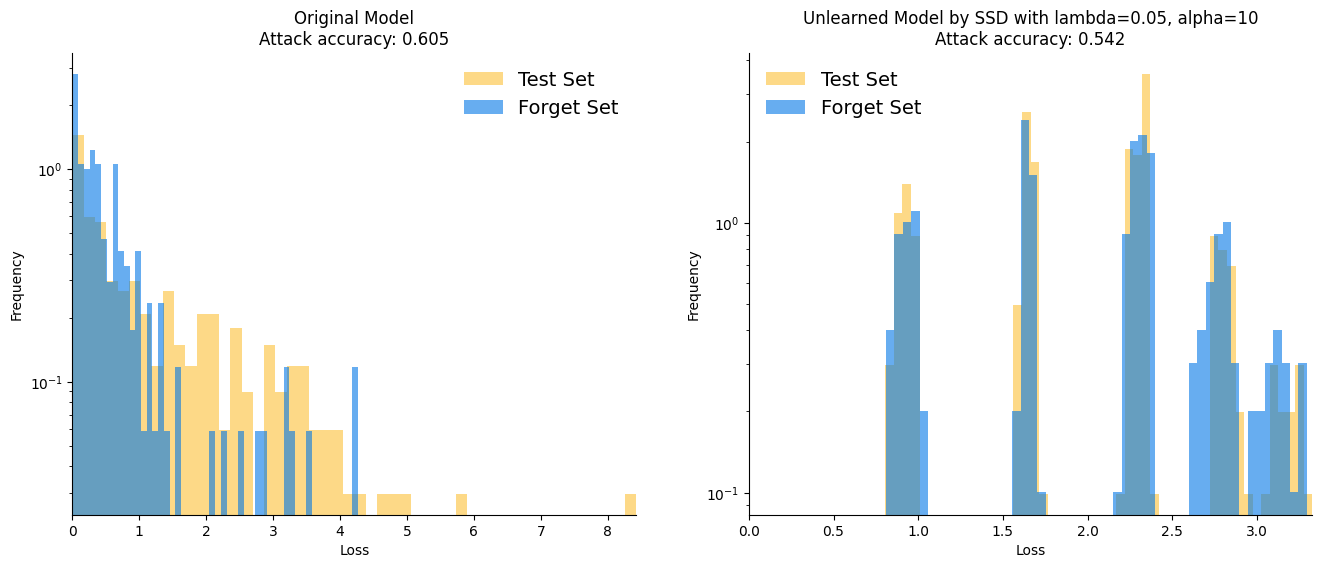

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=0.05, alpha=10")

============ Metrics for Original Model ============
Train Accuracy: 78.2%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=0.1, alpha=10 ============
Train Accuracy: 69.5%
Test Accuracy: 61.4%
MIA score: 0.5375

Final Score: 0.7697


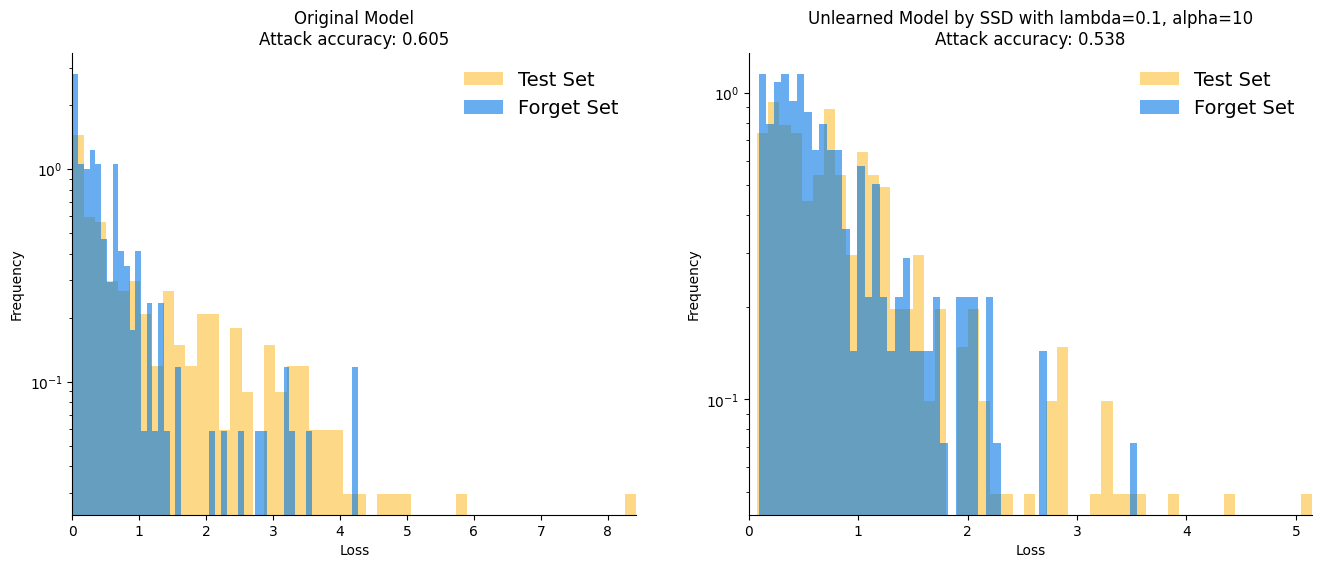

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=0.1, alpha=10")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=0.1, alpha=10 with weighted Cross-Entropy ============
Train Accuracy: 8.5%
Test Accuracy: 11.4%
MIA score: 0.5100

Final Score: 0.5468


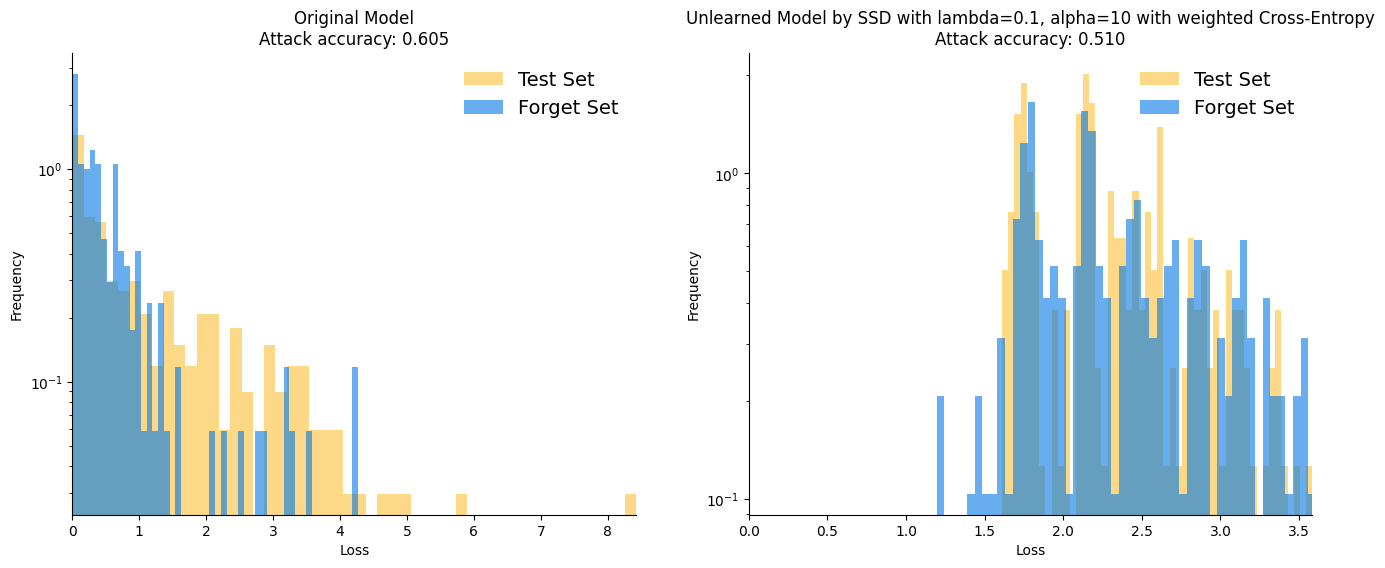

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=0.1, alpha=10 with weighted Cross-Entropy")

============ Metrics for Original Model ============
Train Accuracy: 78.2%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=0.1, alpha=10, adj_stochasticity=1 with weighted Cross-Entropy ============
Train Accuracy: 15.2%
Test Accuracy: 11.4%
MIA score: 0.5475

Final Score: 0.5097


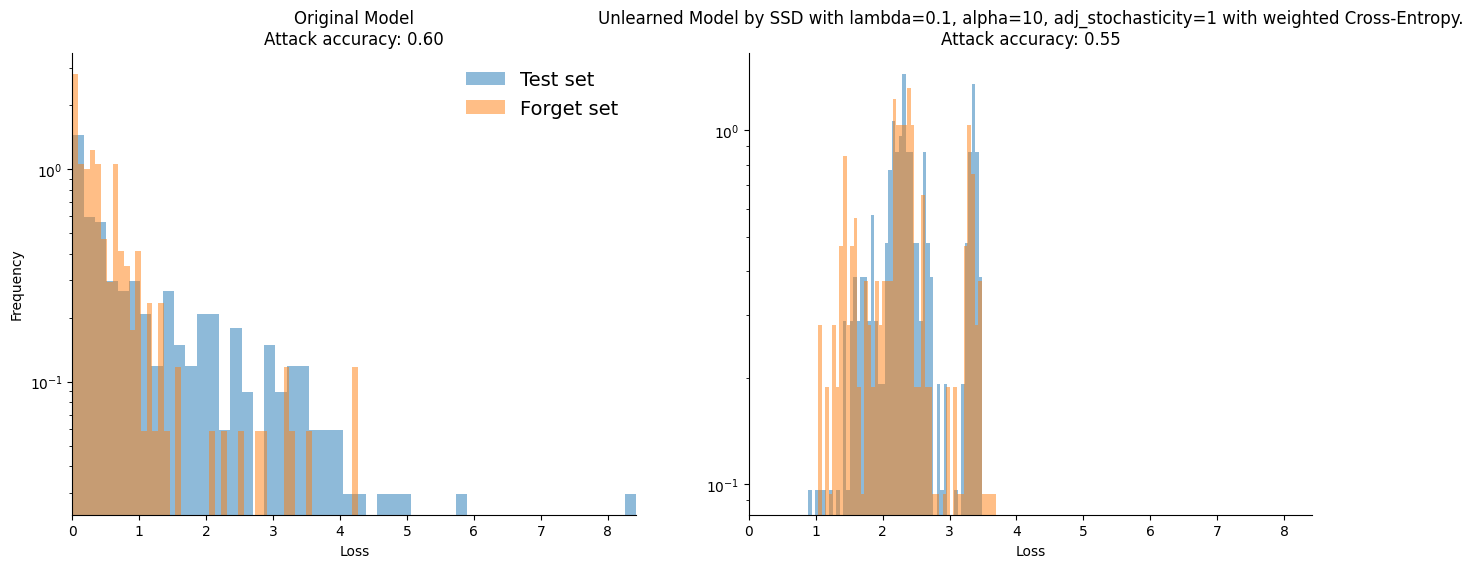

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=0.1, alpha=10, adj_stochasticity=1 with weighted Cross-Entropy")

============ Metrics for Original Model ============
Train Accuracy: 78.2%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=0.1, alpha=10, adj_stochasticity=0.5 with weighted Cross-Entropy and proportion threshold ============
Train Accuracy: 16.9%
Test Accuracy: 13.6%
MIA score: 0.5525

Final Score: 0.5157


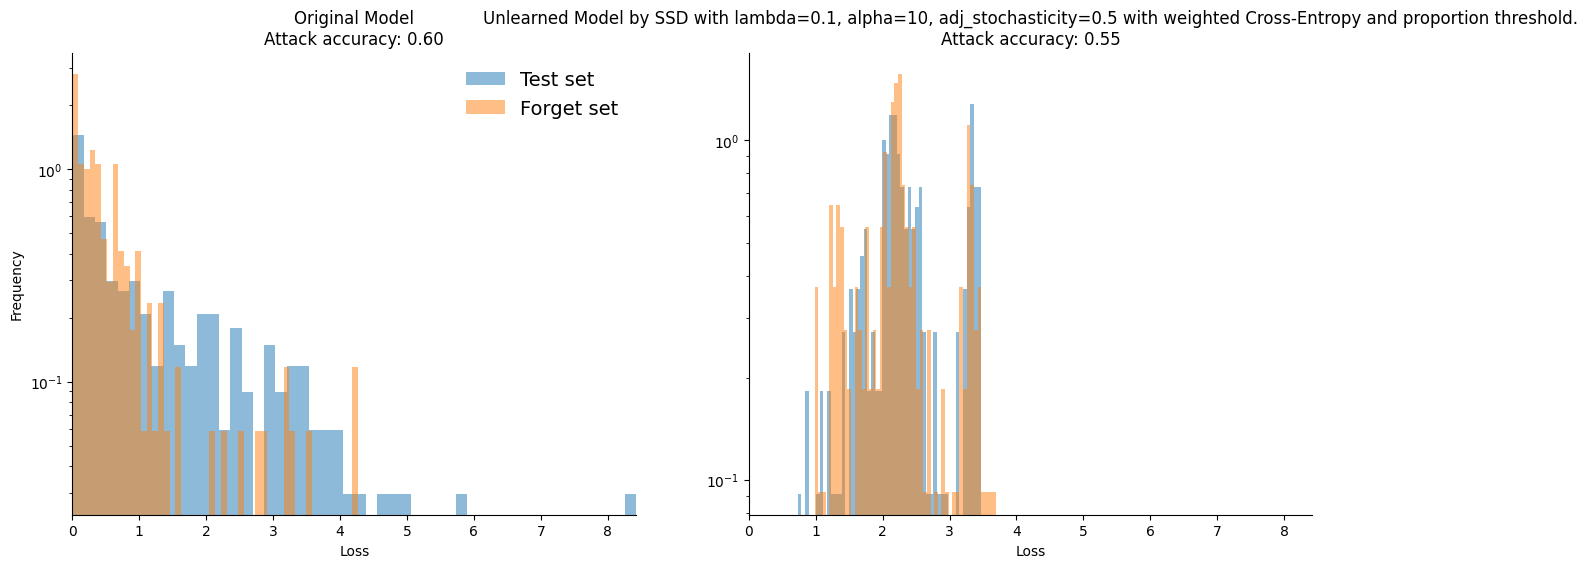

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=0.1, alpha=10, adj_stochasticity=0.5 with weighted Cross-Entropy and proportion threshold")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=0.1, alpha=20 ============
Train Accuracy: 20.1%
Test Accuracy: 18.2%
MIA score: 0.4700

Final Score: 0.5611


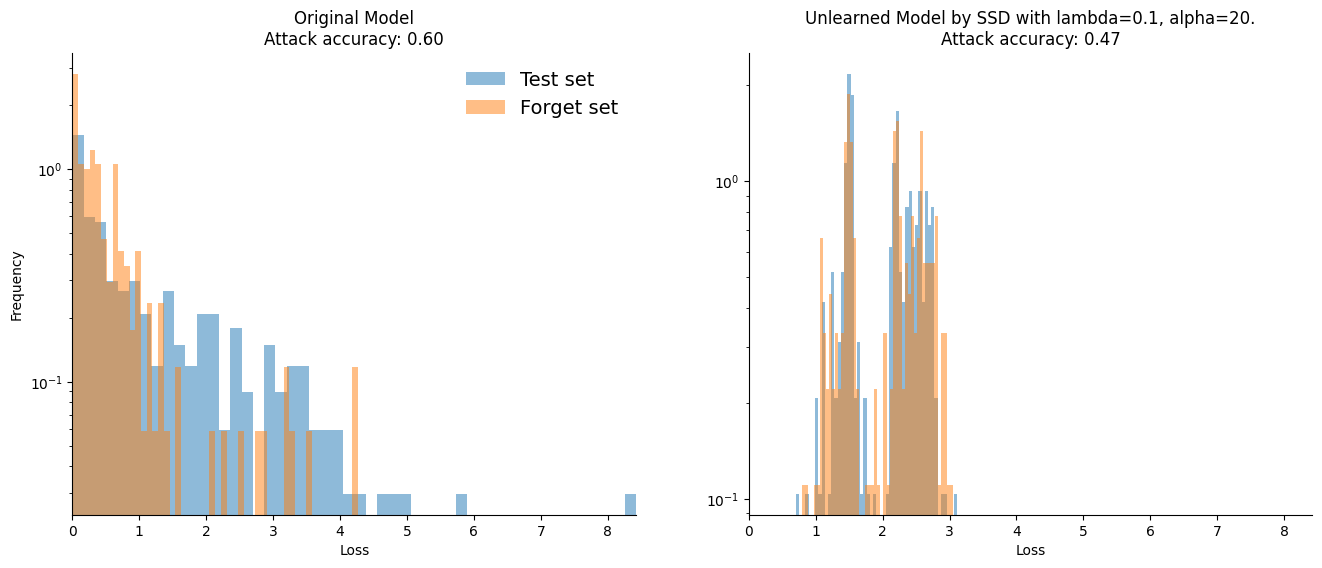

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=0.1, alpha=20")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=0.1, alpha=20 with weighted Cross-Entropy ============
Train Accuracy: 32.7%
Test Accuracy: 26.8%
MIA score: 0.5775

Final Score: 0.5565


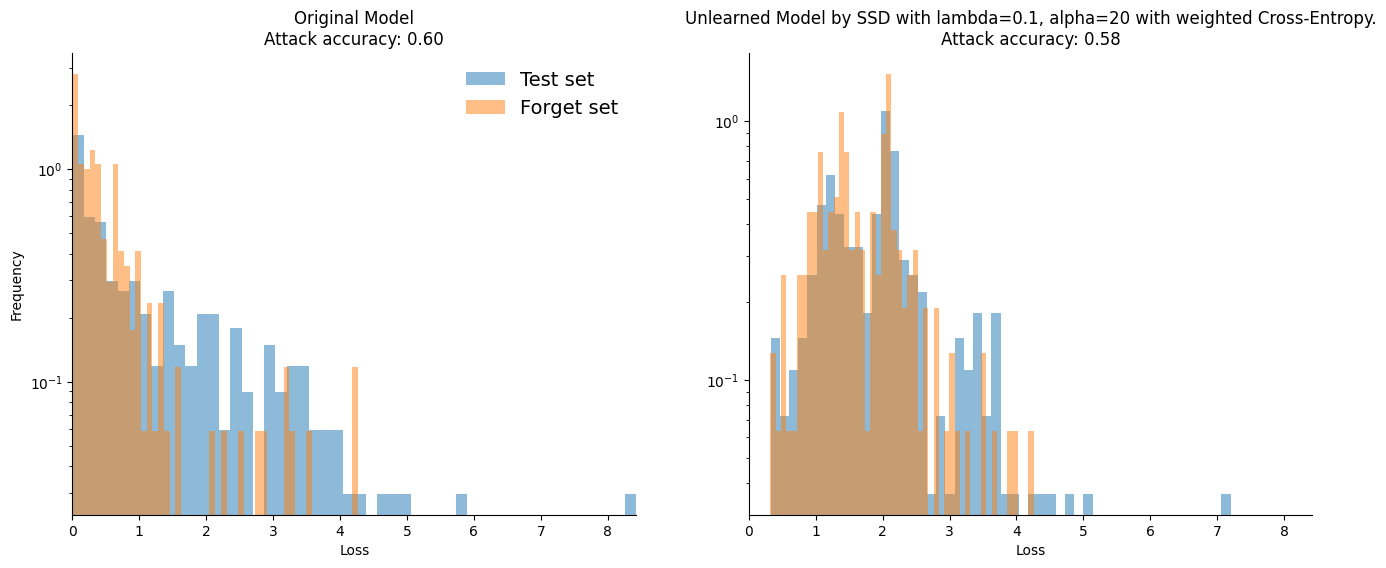

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=0.1, alpha=20 with weighted Cross-Entropy")

============ Metrics for Original Model ============
Train Accuracy: 78.5%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by Stochastic SSD with lambda=0.1, alpha=20, stochasticity=0.5 with weighted Cross-Entropy ============
Train Accuracy: 18.3%
Test Accuracy: 18.4%
MIA score: 0.5550

Final Score: 0.5371


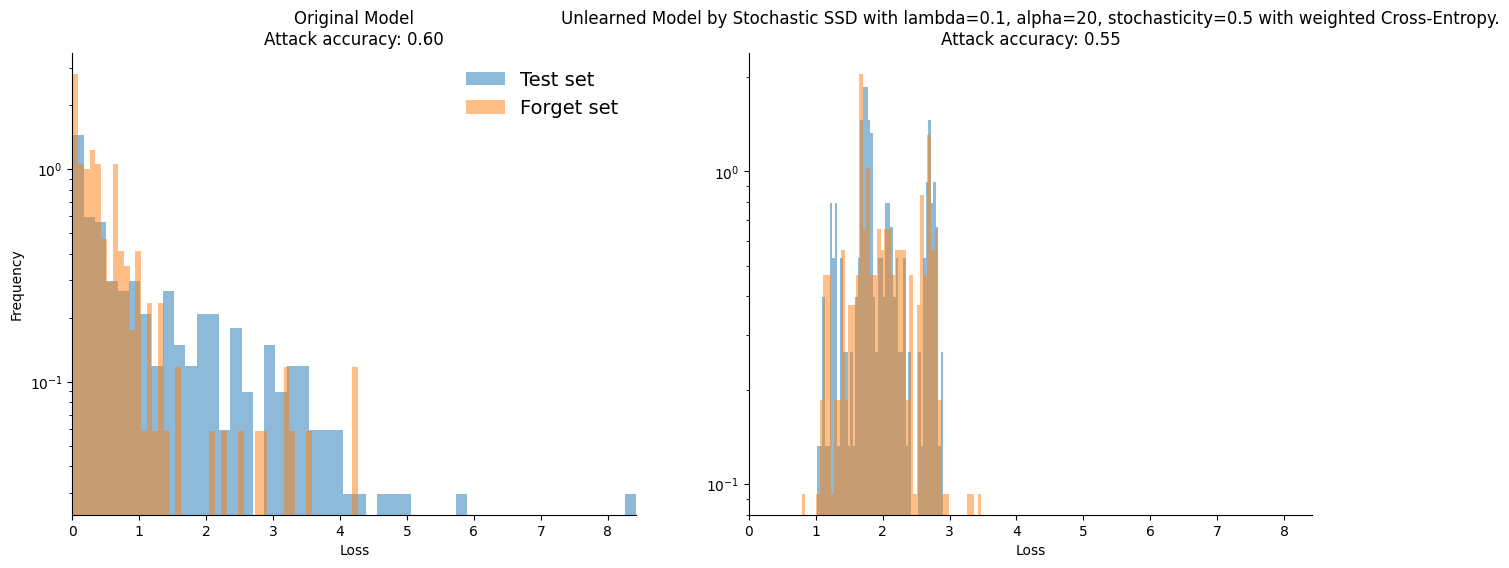

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Stochastic SSD with lambda=0.1, alpha=20, stochasticity=0.5 with weighted Cross-Entropy")

============ Metrics for Original Model ============
Train Accuracy: 78.5%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by Stochastic SSD with lambda=0.1, alpha=20, adj_stochasticity=0.5 with weighted Cross-Entropy ============
Train Accuracy: 18.1%
Test Accuracy: 18.2%
MIA score: 0.5500

Final Score: 0.5408


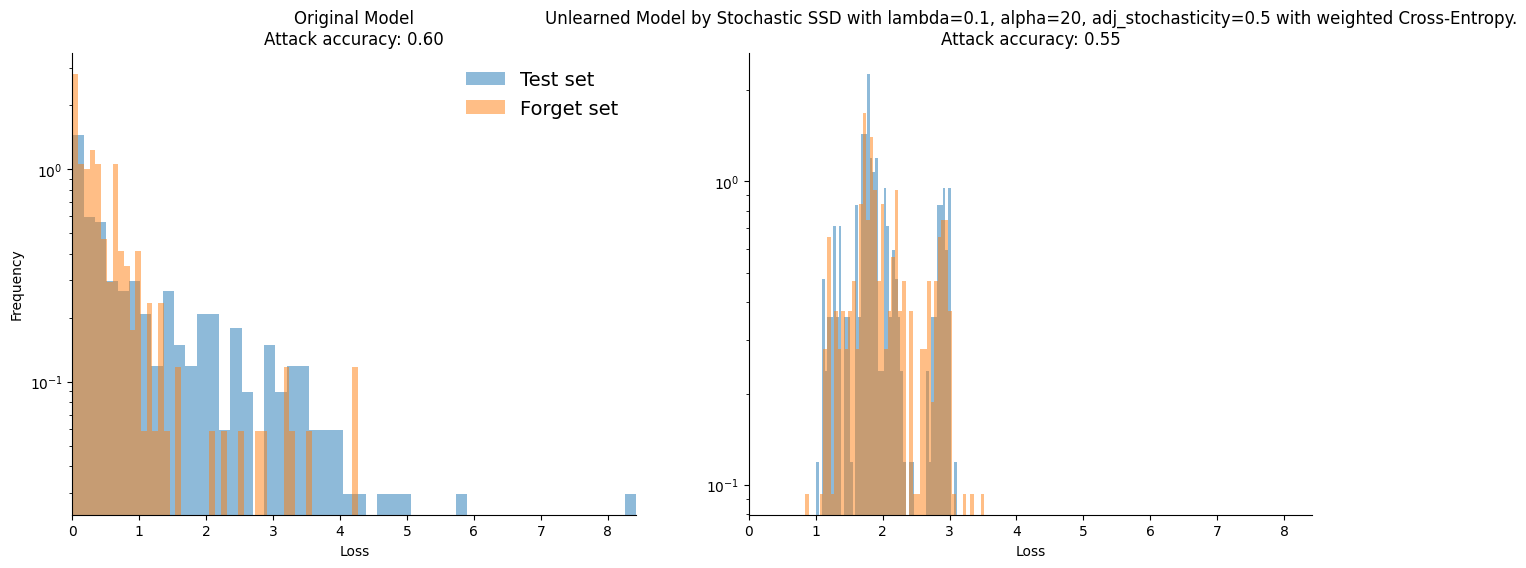

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Stochastic SSD with lambda=0.1, alpha=20, adj_stochasticity=0.5 with weighted Cross-Entropy")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=0.1, alpha=50 ============
Train Accuracy: 64.6%
Test Accuracy: 53.0%
MIA score: 0.5775

Final Score: 0.6875


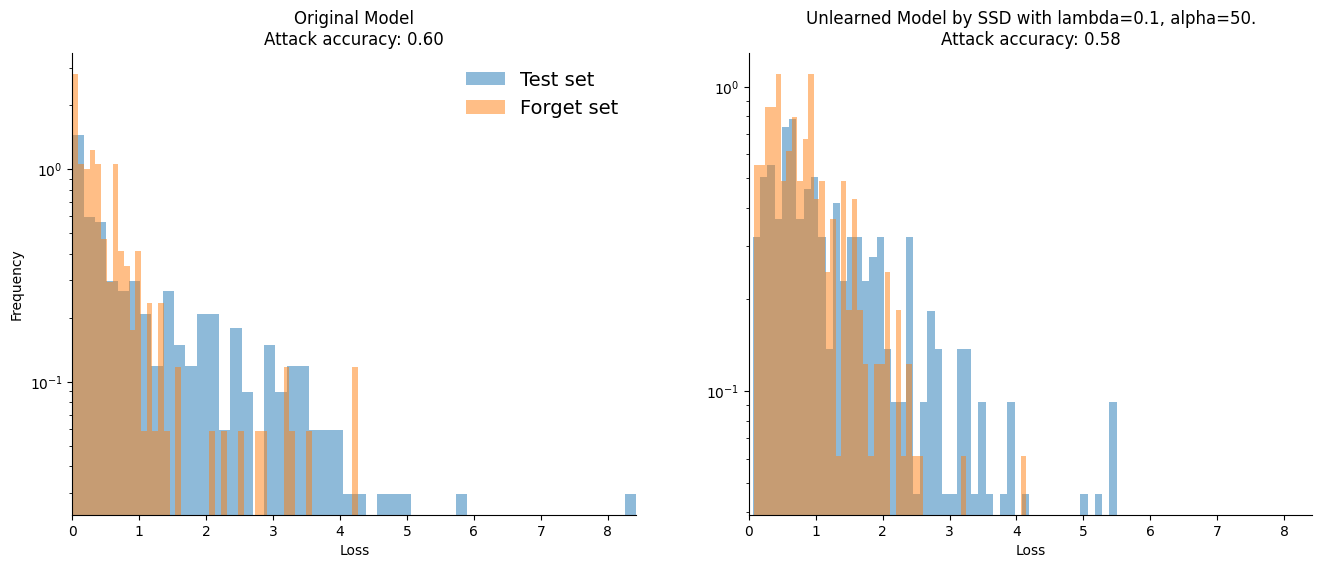

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=0.1, alpha=50")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=0.1, alpha=50 with weighted Cross-Entropy ============
Train Accuracy: 61.3%
Test Accuracy: 44.9%
MIA score: 0.5975

Final Score: 0.6272


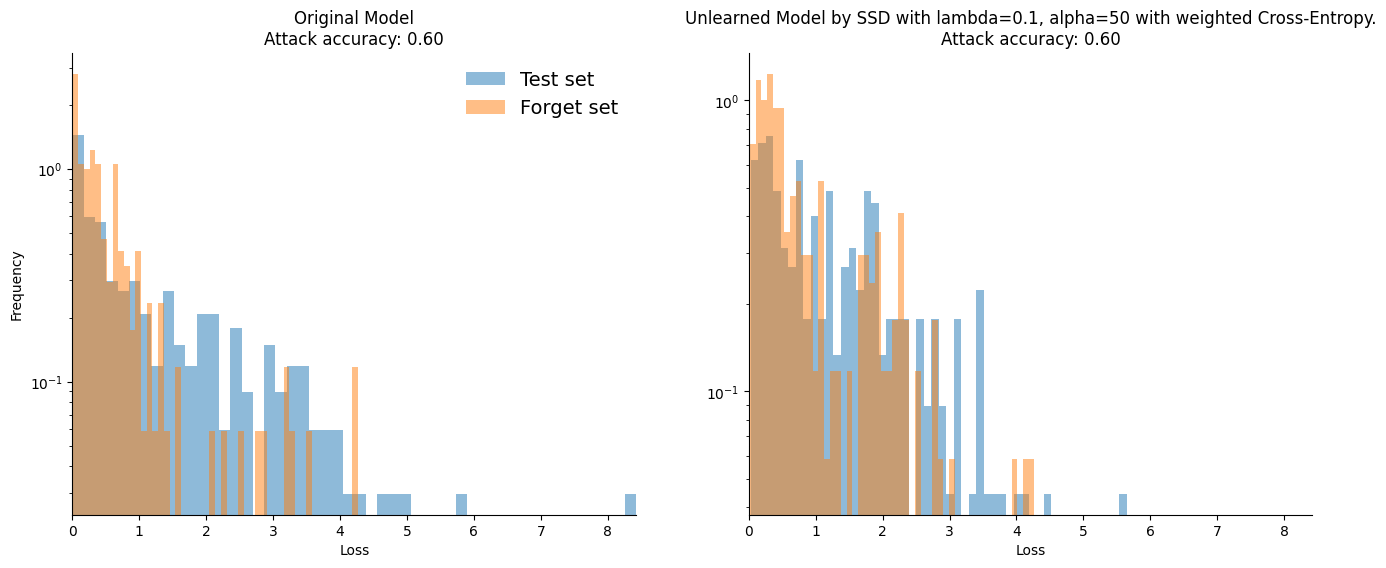

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=0.1, alpha=50 with weighted Cross-Entropy")

============ Metrics for Original Model ============
Train Accuracy: 78.5%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=1, alpha=50 with weighted Cross-Entropy and stochasticity ============
Train Accuracy: 15.2%
Test Accuracy: 11.4%
MIA score: 0.5475

Final Score: 0.5097


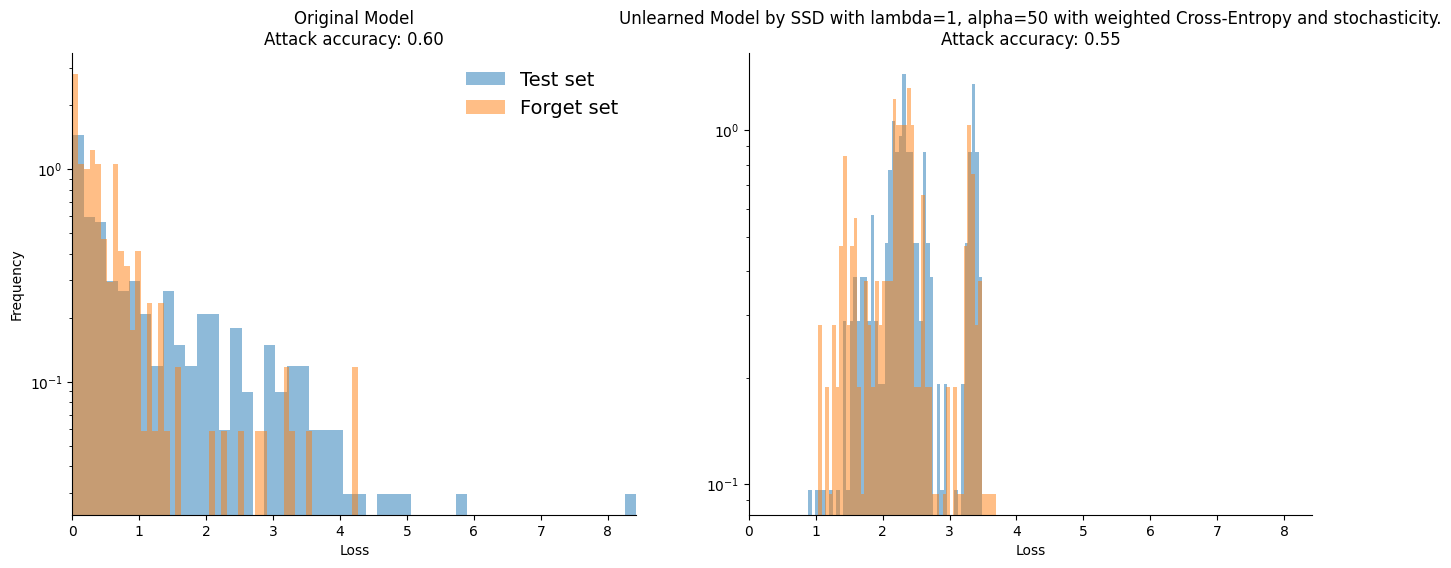

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=1, alpha=50 with weighted Cross-Entropy and stochasticity")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=1, alpha=10 ============
Train Accuracy: 17.2%
Test Accuracy: 18.2%
MIA score: 0.5425

Final Score: 0.5486


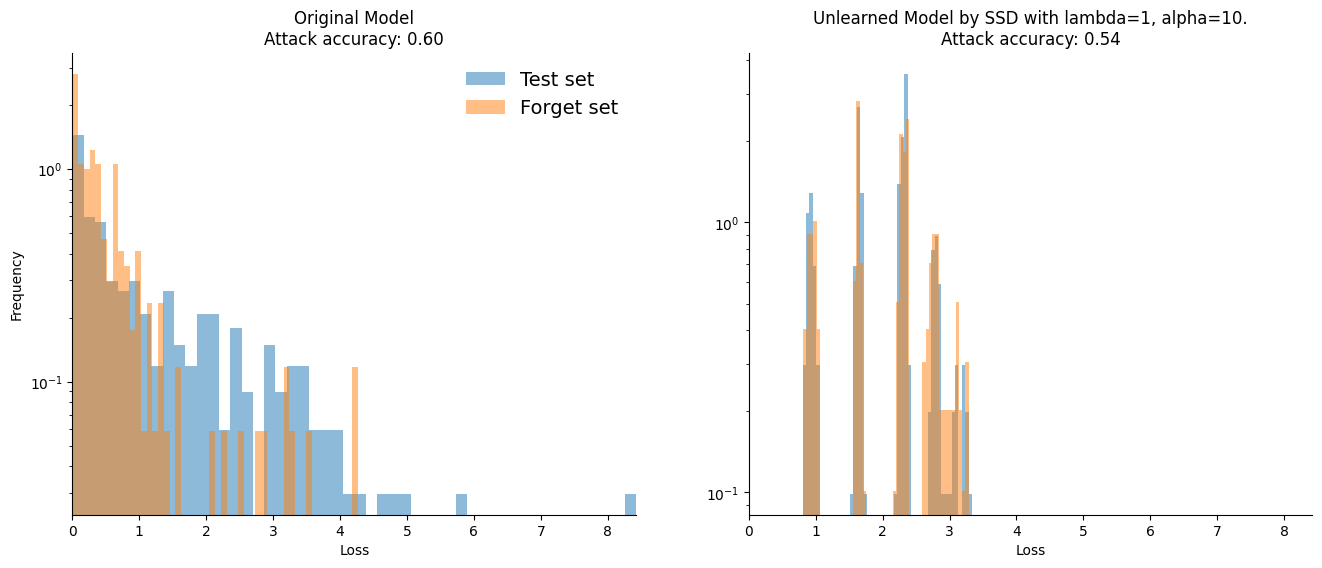

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=1, alpha=10")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=1, alpha=10 with weighted Cross-Entropy ============
Train Accuracy: 8.2%
Test Accuracy: 10.0%
MIA score: 0.4975

Final Score: 0.5474


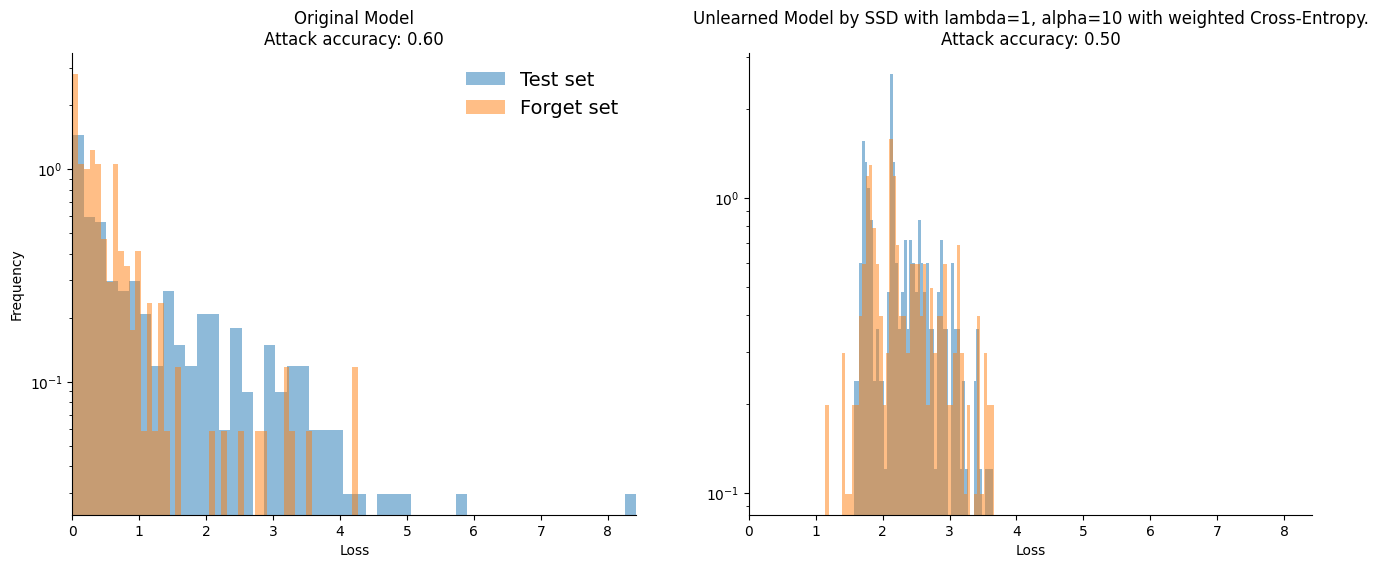

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=1, alpha=10 with weighted Cross-Entropy")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=1, alpha=20 ============
Train Accuracy: 19.9%
Test Accuracy: 18.4%
MIA score: 0.4550

Final Score: 0.5471


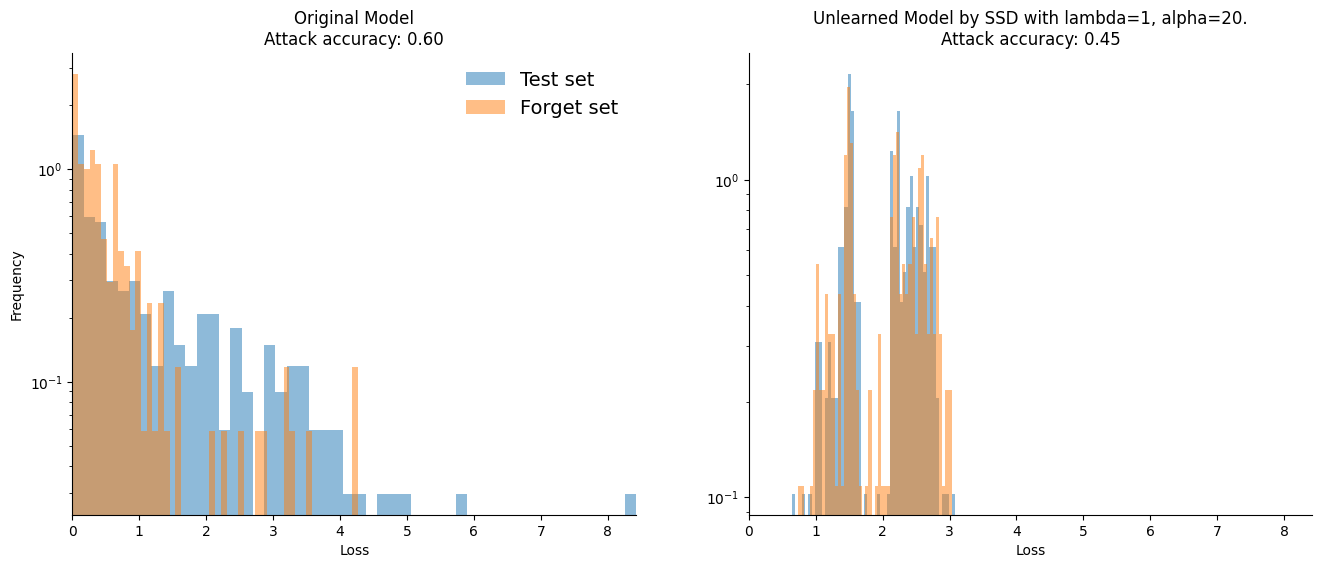

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=1, alpha=20")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=1, alpha=20 with weighted Cross-Entropy ============
Train Accuracy: 33.4%
Test Accuracy: 27.3%
MIA score: 0.5800

Final Score: 0.5563


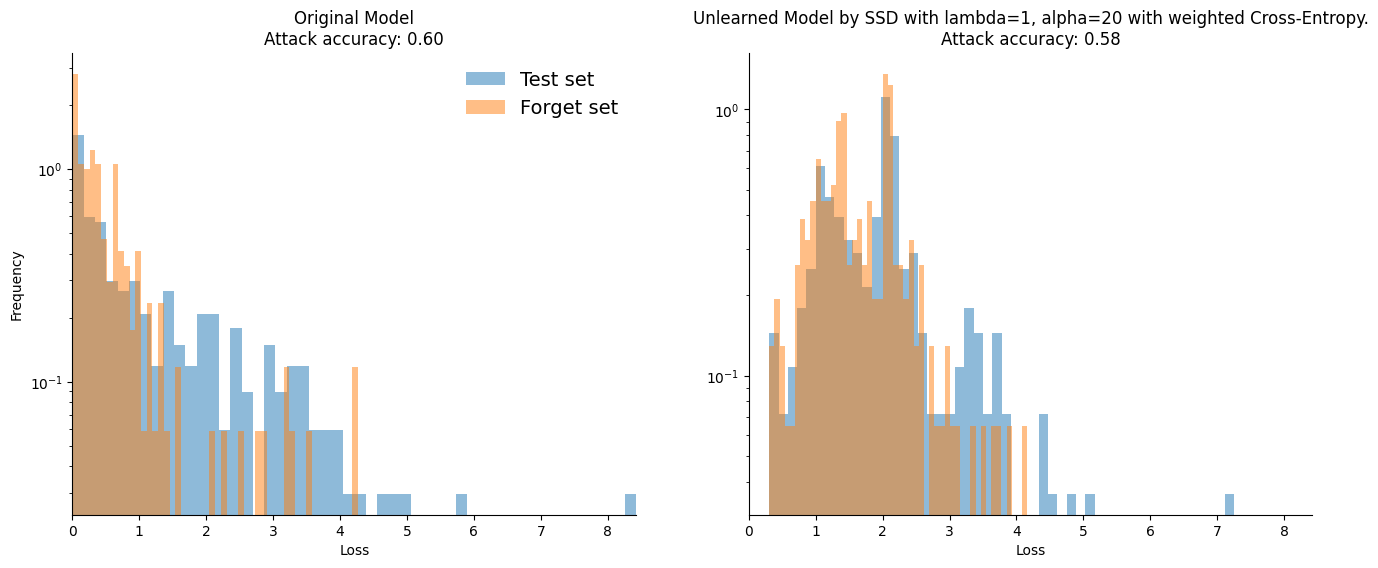

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=1, alpha=20 with weighted Cross-Entropy")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=1, alpha=50 ============
Train Accuracy: 64.9%
Test Accuracy: 53.7%
MIA score: 0.5750

Final Score: 0.6933


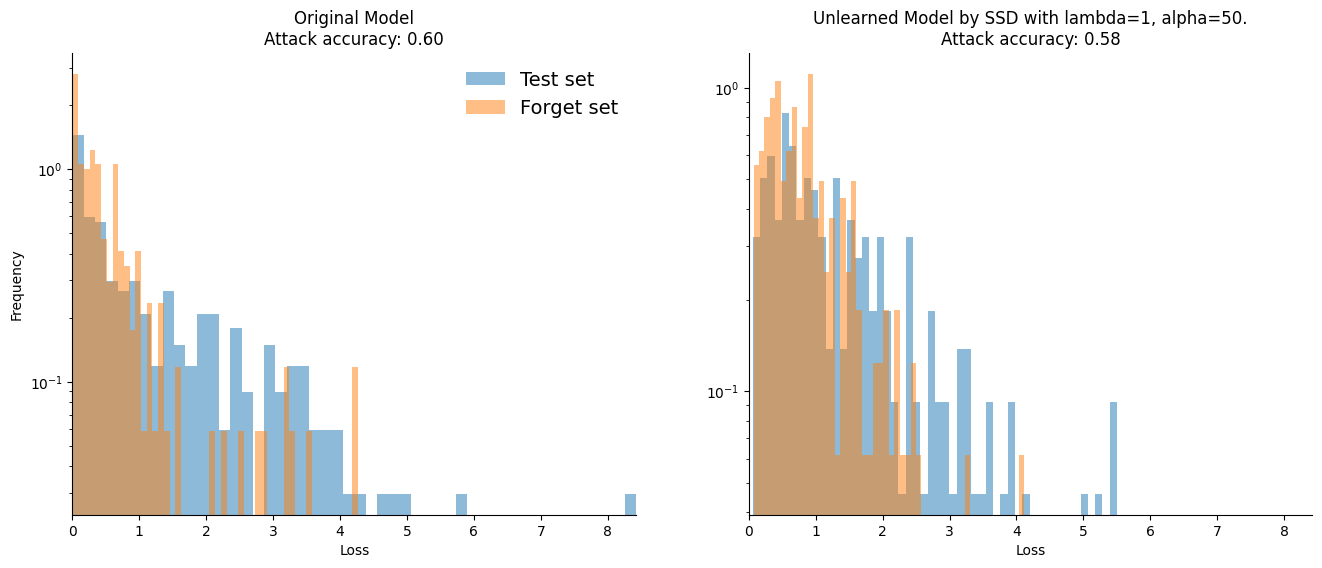

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=1, alpha=50")

============ Metrics for Original Model ============
Train Accuracy: 77.9%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by SSD with lambda=1, alpha=50 with weighted Cross-Entropy ============
Train Accuracy: 61.6%
Test Accuracy: 45.1%
MIA score: 0.5975

Final Score: 0.6282


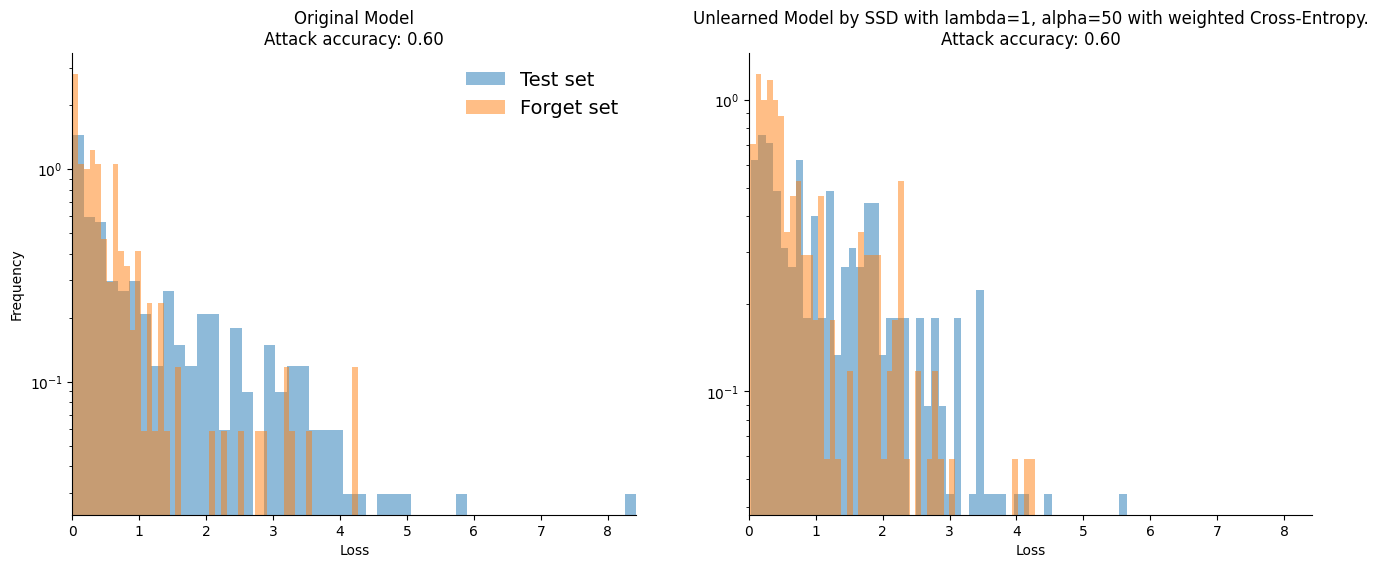

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by SSD with lambda=1, alpha=50 with weighted Cross-Entropy")

## **Approach 4: Gradient-Informed Synaptic Adjustment (GISA)**
Combine SSD and custom loss function ideas



In [ ]:
def compute_param_lr_list(model, retain_importance, forget_importance, base_lr):
    param_lr_list = []

    # Compute scaling factors using logarithm
    for name, param in model.named_parameters():
        retain_imp = retain_importance.get(name, torch.zeros_like(param))
        forget_imp = forget_importance.get(name, torch.zeros_like(param))
        with torch.no_grad():
            # Compute log of the ratio and clamp negative values to 0
            log_ratio = torch.log(forget_imp / (retain_imp + 1e-8))
            clamped_log_ratio = torch.clamp(log_ratio, min=0)

            # Use the mean of the clamped log ratio as the scaling factor
            scaling_factor = clamped_log_ratio.mean().item()

            # Scale the base learning rate
            scaled_lr = base_lr * (1 + scaling_factor)
            param_lr_list.append({'params': [param], 'lr': scaled_lr})

    return param_lr_list



def unlearning_adaptive_ssd(net, retain_loader, forget_loader, val_loader, retain_class_weights=None, forget_class_weights=None, DEVICE='cuda'):
    epochs = 3
    base_lr = 0.00001

    # Initialization for SSD
    optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
    # Parameters are NOT USED in this approach!!!
    parameters = {
        "lower_bound": 1,
        "exponent": 1,
        "magnitude_diff": None,
        "min_layer": -1,
        "max_layer": -1,
        "forget_threshold": 1,
        "dampening_constant": 0.1,  # lambda 0.1, 0.5, 1, 1.5, 2, 3, 5
        "selection_weighting": 10,  # alpha 1, 5, 10, 20, 30, 40, 50
    }
    pdr = ParameterPerturber(net, optimizer, DEVICE, parameters)

    retain_importance = pdr.calc_importance(retain_loader, retain_class_weights)
    forget_importance = pdr.calc_importance(forget_loader, forget_class_weights)
    # retain_importance = pdr.calc_importance(retain_loader)
    # forget_importance = pdr.calc_importance(forget_loader)

    param_lr_list = compute_param_lr_list(net, retain_importance, forget_importance, base_lr)


    retain_criterion = nn.CrossEntropyLoss(weight=retain_class_weights)
    forget_criterion = nn.CrossEntropyLoss(weight=forget_class_weights)
    # retain_criterion = nn.CrossEntropyLoss()
    # forget_criterion = nn.CrossEntropyLoss()
    # optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
    # optimizer = optim.Adam(net.parameters(), lr=0.0001, weight_decay=5e-3)

    optimizer = optim.Adam(param_lr_list, weight_decay=5e-3)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    net.train()

    forget_iterator = iter(forget_loader)

    for _ in range(epochs):

        for retain_inputs, retain_targets in retain_loader:
            retain_inputs, retain_targets = retain_inputs.to(DEVICE), retain_targets.to(DEVICE)
            try:
                (forget_inputs, forget_targets) = next(forget_iterator)
            except StopIteration:
                forget_iterator = iter(forget_loader)
                (forget_inputs, forget_targets) = next(forget_iterator)
            forget_inputs, forget_targets = forget_inputs.to(DEVICE), forget_targets.to(DEVICE)
            if forget_inputs.size(0) != retain_inputs.size(0):
                continue

            optimizer.zero_grad()
            retain_outputs = net(retain_inputs)
            forget_outputs = net(forget_inputs)

            retain_loss = retain_criterion(retain_outputs, retain_targets)
            forget_loss = forget_criterion(forget_outputs, forget_targets)

            # Overall loss
            joint_loss = (retain_loss**2)/forget_loss

            # Accumulate gradients
            joint_loss.backward()

            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)

            # Update model parameters
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [ ]:
unlearned_model = copy.deepcopy(original_model)
unlearned_model = unlearning_adaptive_ssd(unlearned_model, retain_loader, forget_loader, val_loader, retain_class_weights, forget_class_weights, DEVICE)

{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}


In [ ]:
# base lr = 0.00001, wd = 5e-3, epochs=3
ret = score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader, original_model, retrained_model, unlearning_adaptive_ssd, 10)
ret

  0%|          | 0/10 [00:00<?, ?it/s]

{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 10}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_we

  0%|          | 0/200 [00:00<?, ?it/s]

{'total_score': 0.07119158075001612,
 'F': 0.073299560546875,
 'unlearn_retain_accuracy': 0.8089465648854961,
 'unlearn_test_accuracy': 0.6441489361702127,
 'unlearn_forget_accuracy': 0.582,
 'retrain_retain_accuracy': 0.862086513994911,
 'retrain_test_accuracy': 0.6223404255319149,
 'retrain_forget_accuracy': 0.73,
 'retrain_outputs': array([[0.11770556, 0.2228199 , 0.09327468, ..., 0.23627493, 0.04017649,
         1.16231253],
        [0.11568225, 0.24851873, 0.09577805, ..., 0.23914711, 0.04089435,
         1.1545326 ],
        [0.1148995 , 0.2331599 , 0.09625281, ..., 0.24024398, 0.04289978,
         1.15401294],
        ...,
        [0.11209865, 0.22577312, 0.09463036, ..., 0.23356013, 0.0401786 ,
         1.1565698 ],
        [0.11579523, 0.24767359, 0.09817378, ..., 0.24195165, 0.04353591,
         1.15224398],
        [0.11464761, 0.23676545, 0.08955143, ..., 0.23648134, 0.04171766,
         1.140491  ]]),
 'unlearn_outputs': array([[0.03374974, 0.25895822, 0.11334731, ..., 0.2

============ Metrics for Original Model ============
Train Accuracy: 77.8%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget, weighted importances and importance-scaled learning rate ============
Train Accuracy: 62.3%
Test Accuracy: 53.3%
MIA score: 0.5450

Final Score: 0.7216


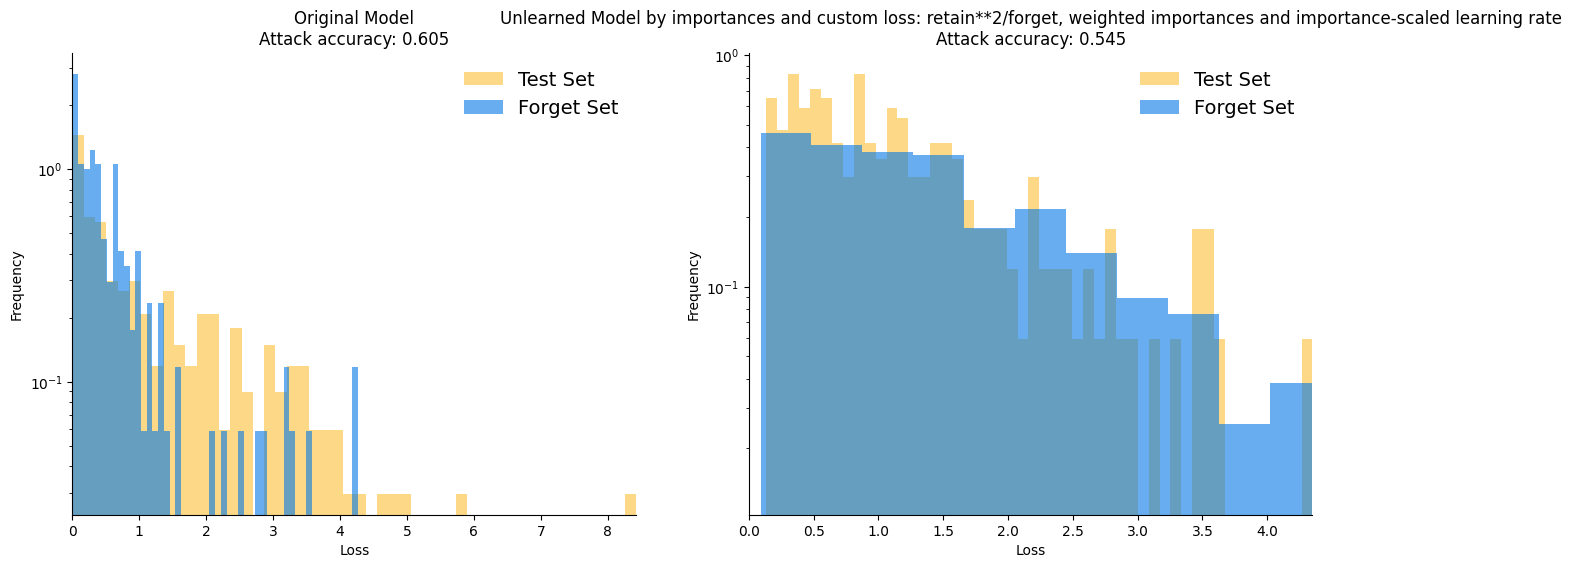

In [ ]:
# weight decay = 1e-2
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget, weighted importances and importance-scaled learning rate")

============ Metrics for Original Model ============
Train Accuracy: 78.1%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy ============
Train Accuracy: 70.7%
Test Accuracy: 58.6%
MIA score: 0.5425

Final Score: 0.7507


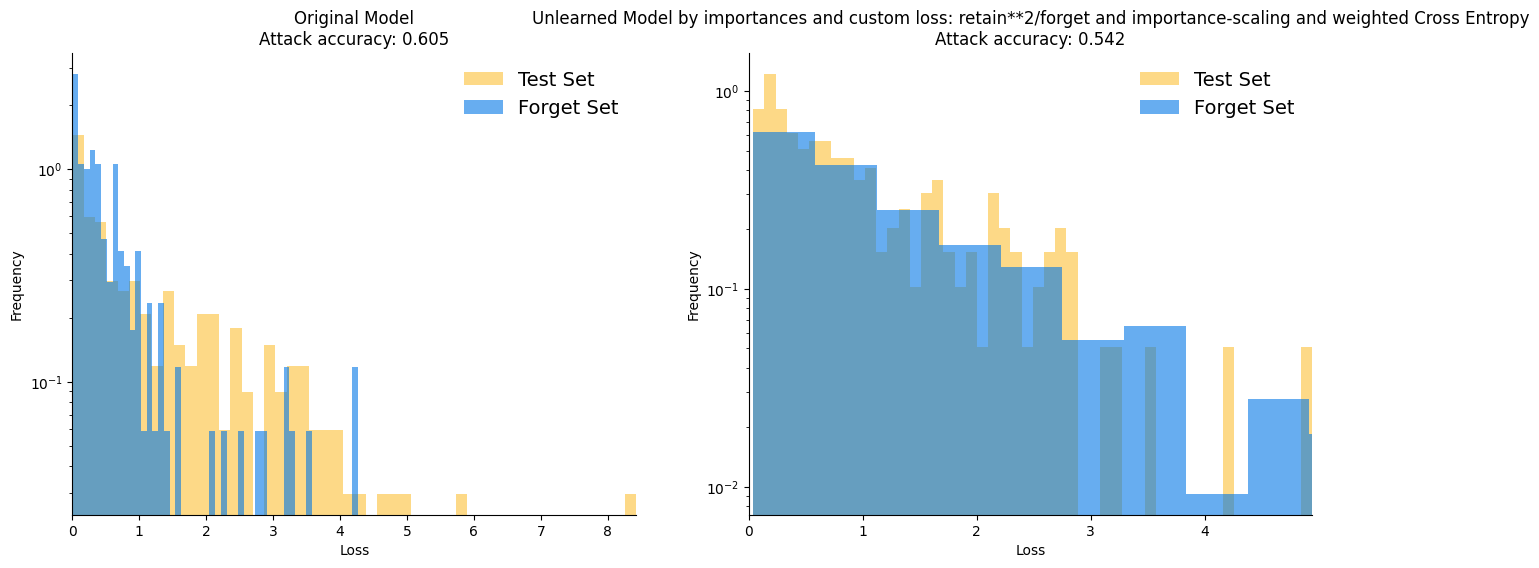

In [ ]:
# weight decay = 5e-3
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy")

============ Metrics for Original Model ============
Train Accuracy: 77.8%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy ============
Train Accuracy: 74.7%
Test Accuracy: 62.8%
MIA score: 0.5300

Final Score: 0.7838


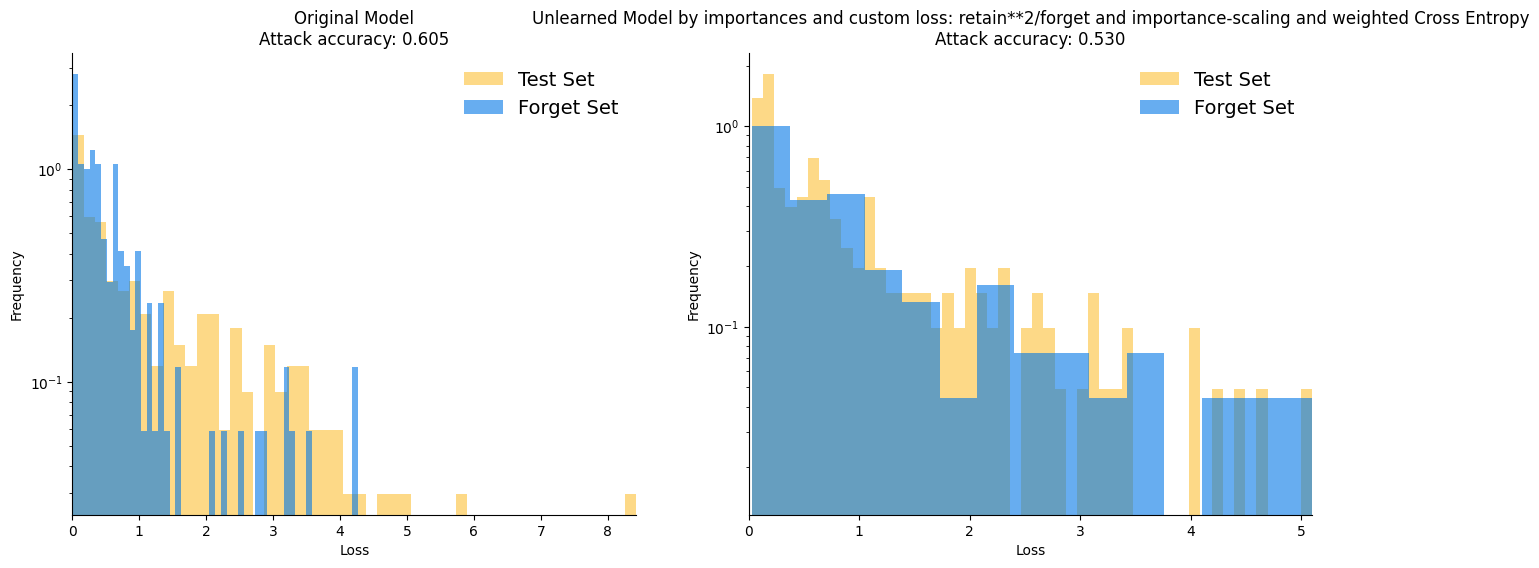

In [ ]:
# weight decay = 5e-3, lr=0.00005
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy")

============ Metrics for Original Model ============
Train Accuracy: 77.8%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy ============
Train Accuracy: 80.1%
Test Accuracy: 63.2%
MIA score: 0.5525

Final Score: 0.7637


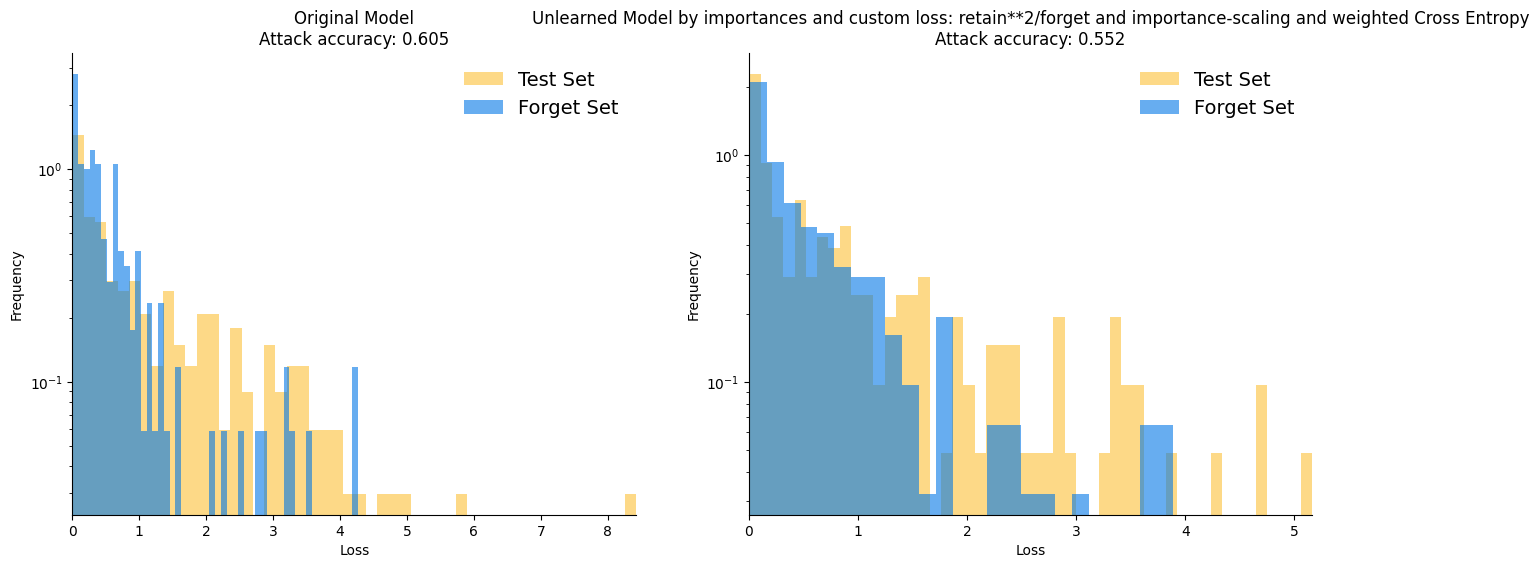

In [ ]:
# weight decay = 5e-3, lr=0.00001, 1 epoch
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy")

============ Metrics for Original Model ============
Train Accuracy: 78.7%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy (2 epochs) ============
Train Accuracy: 80.9%
Test Accuracy: 63.6%
MIA score: 0.5150

Final Score: 0.8028


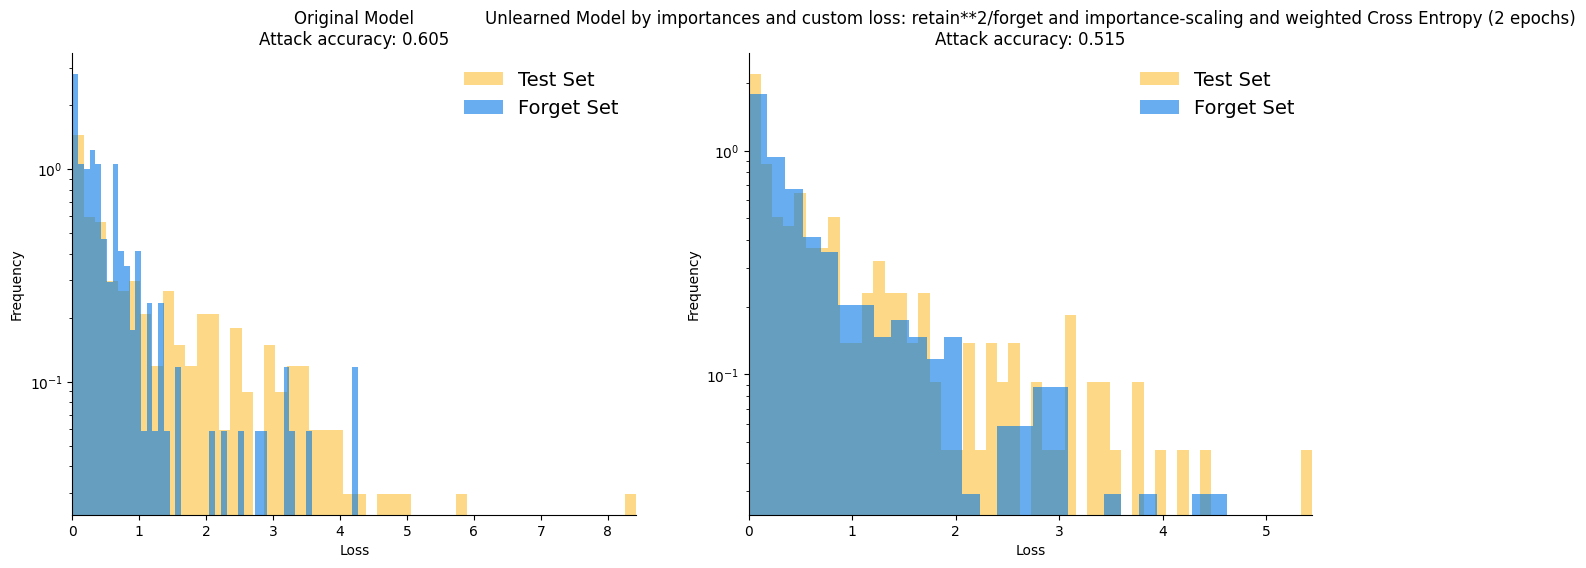

In [ ]:
# weight decay = 5e-3, lr=0.00001, 2 epoch
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy (2 epochs)")

============ Metrics for Original Model ============
Train Accuracy: 78.6%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy (3 epochs) ============
Train Accuracy: 80.4%
Test Accuracy: 65.0%
MIA score: 0.4875

Final Score: 0.8126


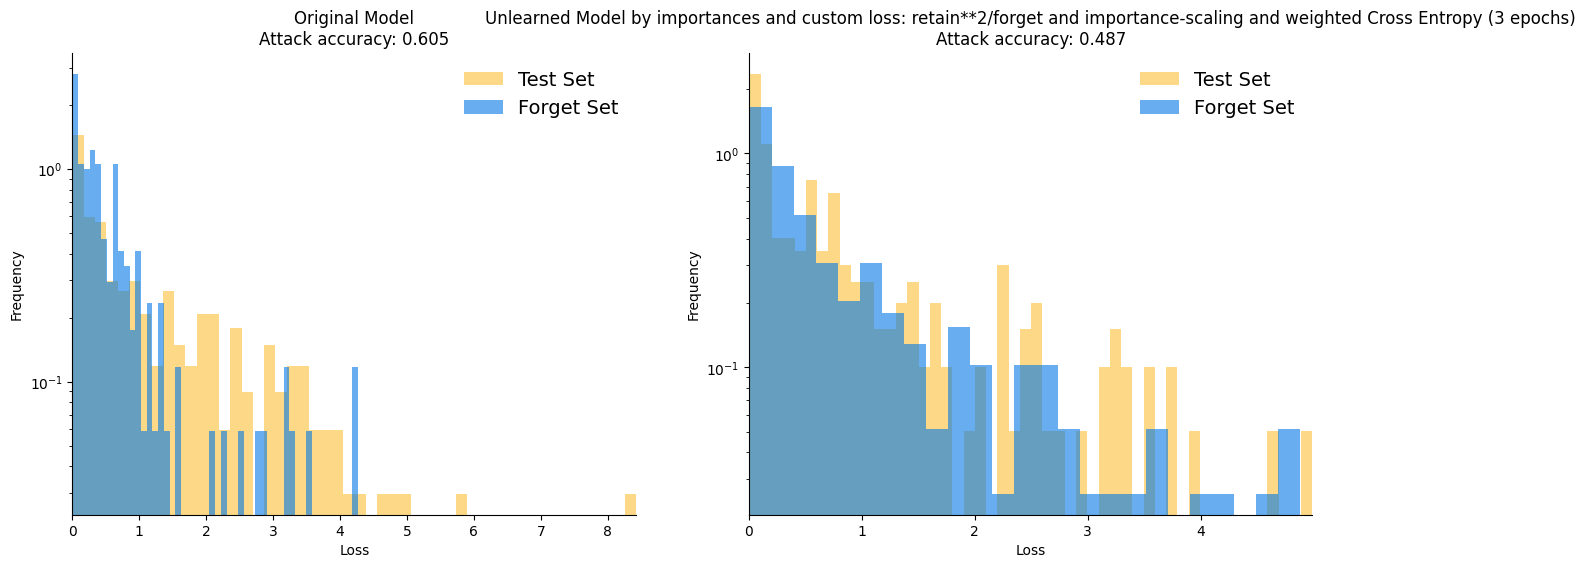

In [ ]:
# weight decay = 5e-3, lr=0.00001, 3 epoch
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy (3 epochs)")

============ Metrics for Original Model ============
Train Accuracy: 77.8%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy ============
Train Accuracy: 68.9%
Test Accuracy: 57.2%
MIA score: 0.5325

Final Score: 0.7534


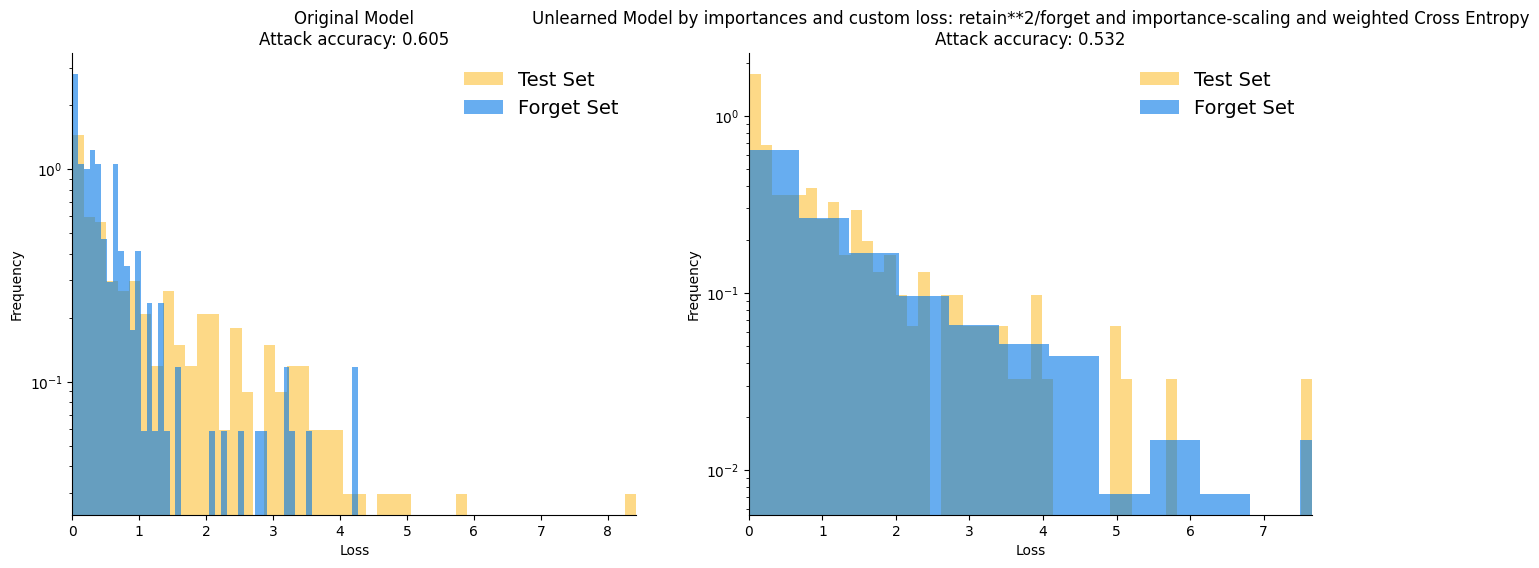

In [ ]:
# weight decay = 1e-3
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy")

============ Metrics for Original Model ============
Train Accuracy: 77.8%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy ============
Train Accuracy: 68.5%
Test Accuracy: 57.4%
MIA score: 0.5075

Final Score: 0.7797


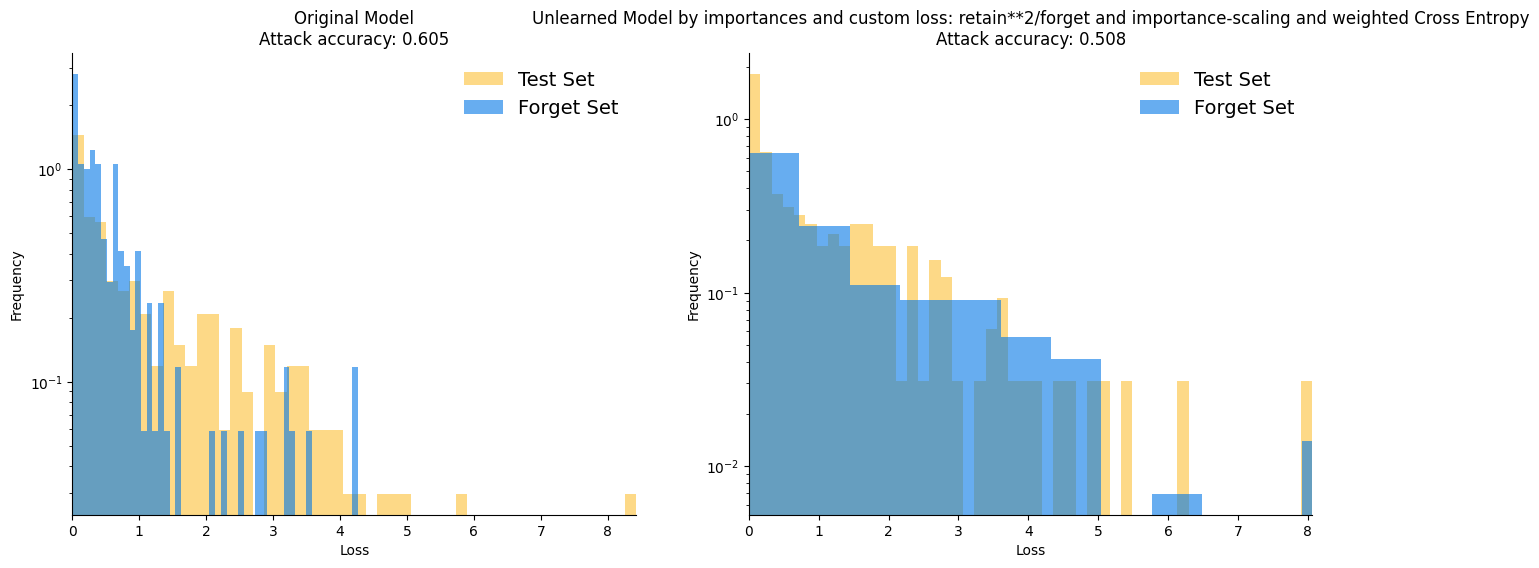

In [ ]:
# weight decay = 5e-4
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget and importance-scaling and weighted Cross Entropy")

============ Metrics for Original Model ============
Train Accuracy: 77.8%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.6999
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget and scaling and weighted Cross Entropy (with scaling=1 + log) ============
Train Accuracy: 66.6%
Test Accuracy: 55.7%
MIA score: 0.5325

Final Score: 0.7458


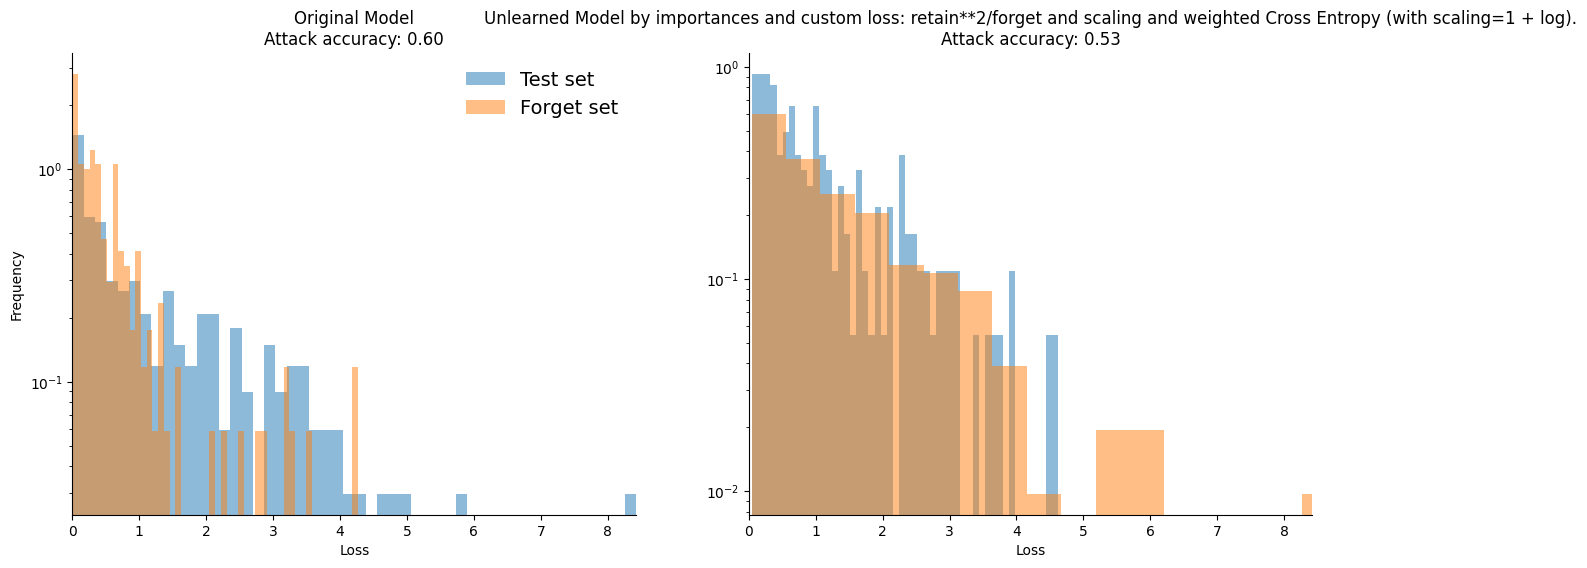

In [ ]:
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget and scaling and weighted Cross Entropy (with scaling=1 + log)")

============ Metrics for Original Model ============
Train Accuracy: 77.8%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.6999
============ Metrics for Unlearned Model by importances and custom loss: retain**2/forget and scaling and weighted Cross Entropy (without log) ============
Train Accuracy: 27.9%
Test Accuracy: 23.1%
MIA score: 0.4875

Final Score: 0.6032


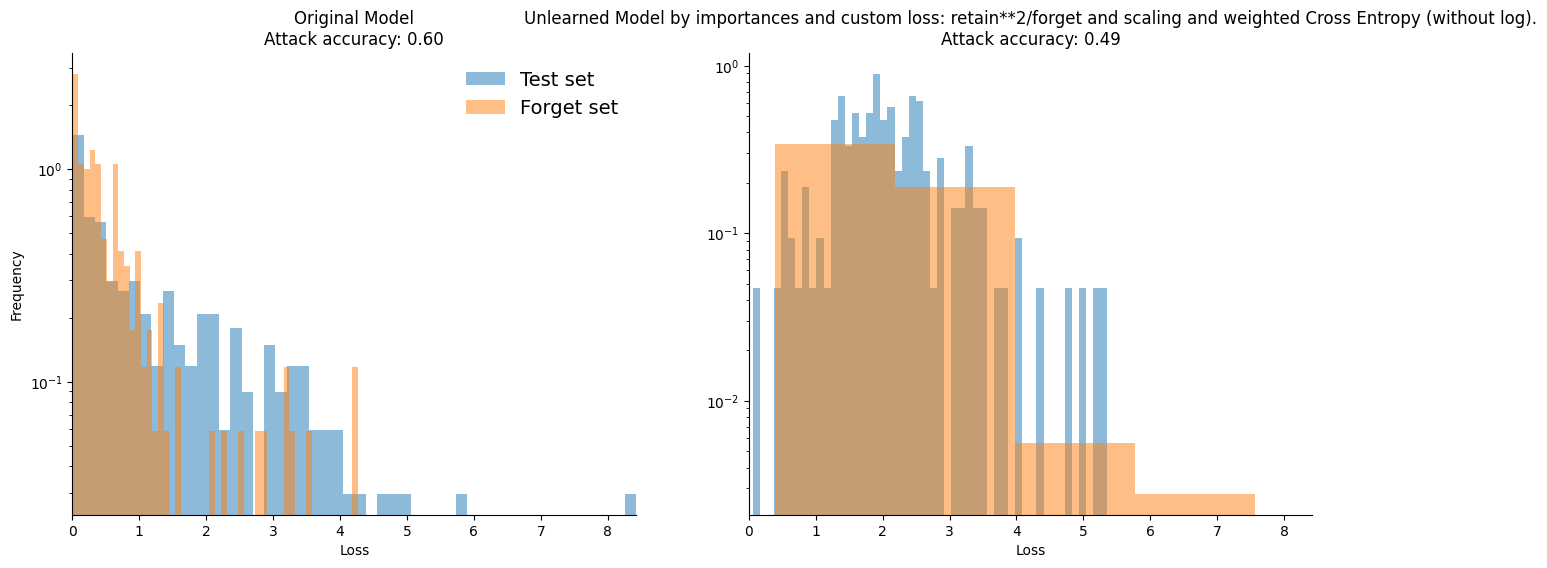

In [ ]:
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain**2/forget and scaling and weighted Cross Entropy (without log)")

============ Metrics for Original Model ============
Train Accuracy: 77.7%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss (forget_weight = 0.1, no scaling) ============
Train Accuracy: 79.9%
Test Accuracy: 63.2%
MIA score: 0.5500

Final Score: 0.7658


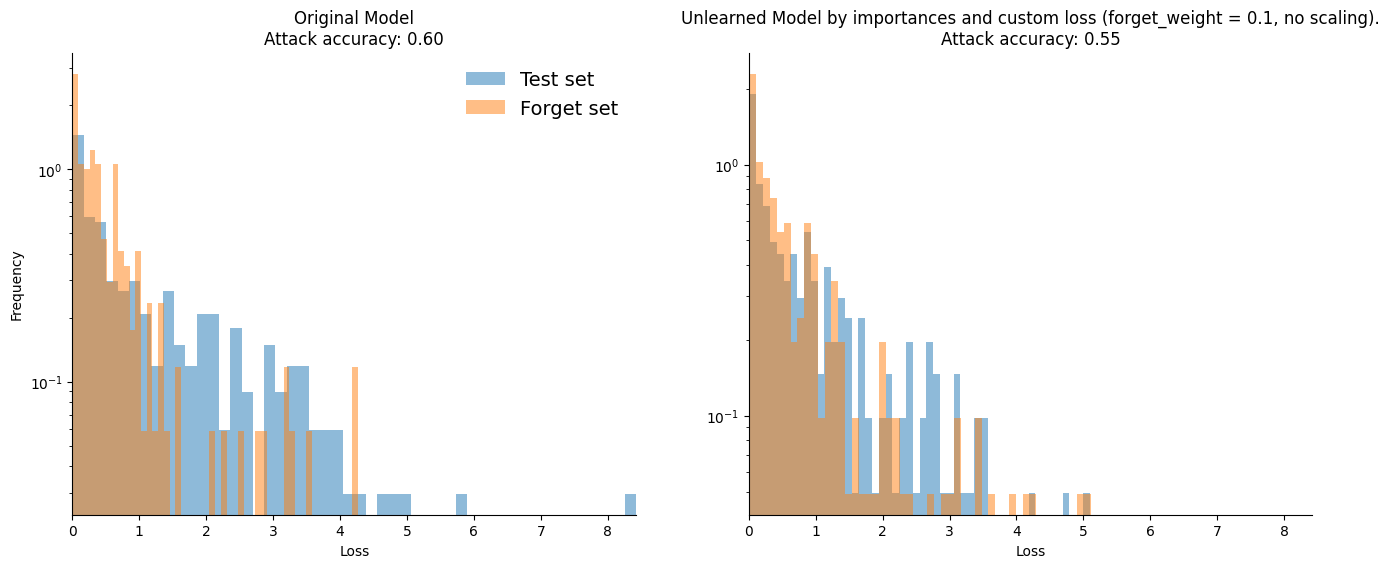

In [ ]:
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss (forget_weight = 0.1, no scaling)")

============ Metrics for Original Model ============
Train Accuracy: 78.0%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: - neg_grad_factor*(forget_loss/retain_loss**2) ============
Train Accuracy: 72.4%
Test Accuracy: 56.6%
MIA score: 0.5500

Final Score: 0.7329


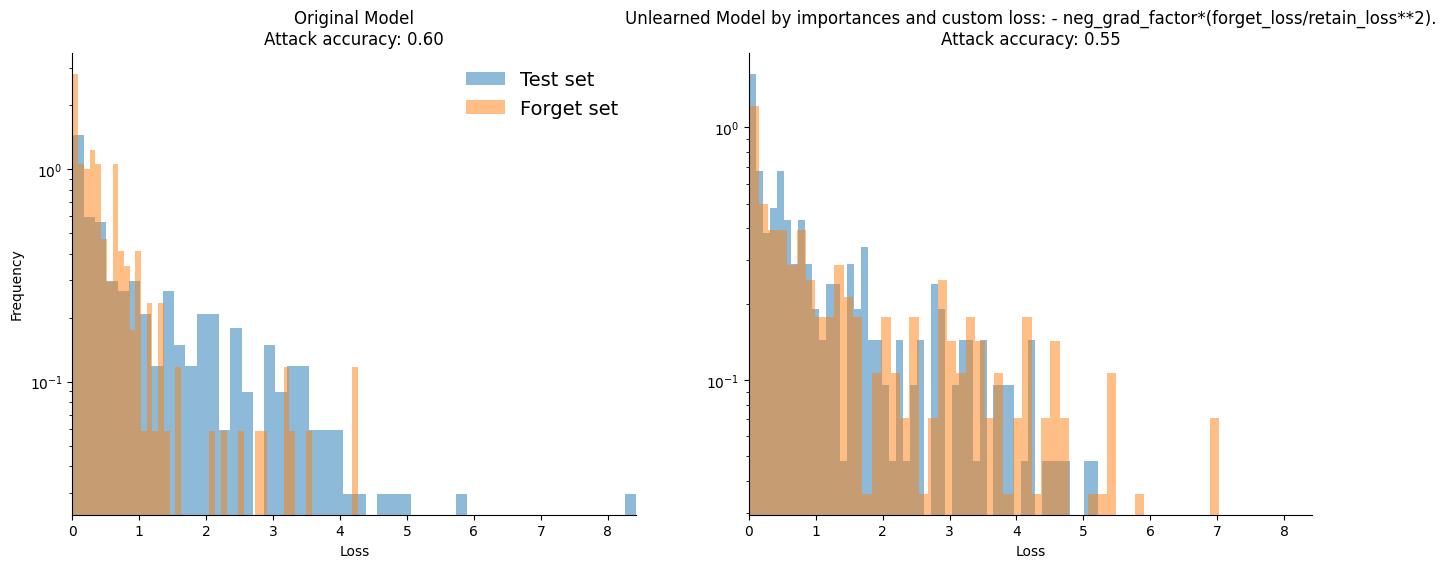

In [ ]:
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: - neg_grad_factor*(forget_loss/retain_loss**2)")

============ Metrics for Original Model ============
Train Accuracy: 78.0%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain_loss**2/forget_loss ============
Train Accuracy: 72.3%
Test Accuracy: 56.8%
MIA score: 0.5600

Final Score: 0.7239


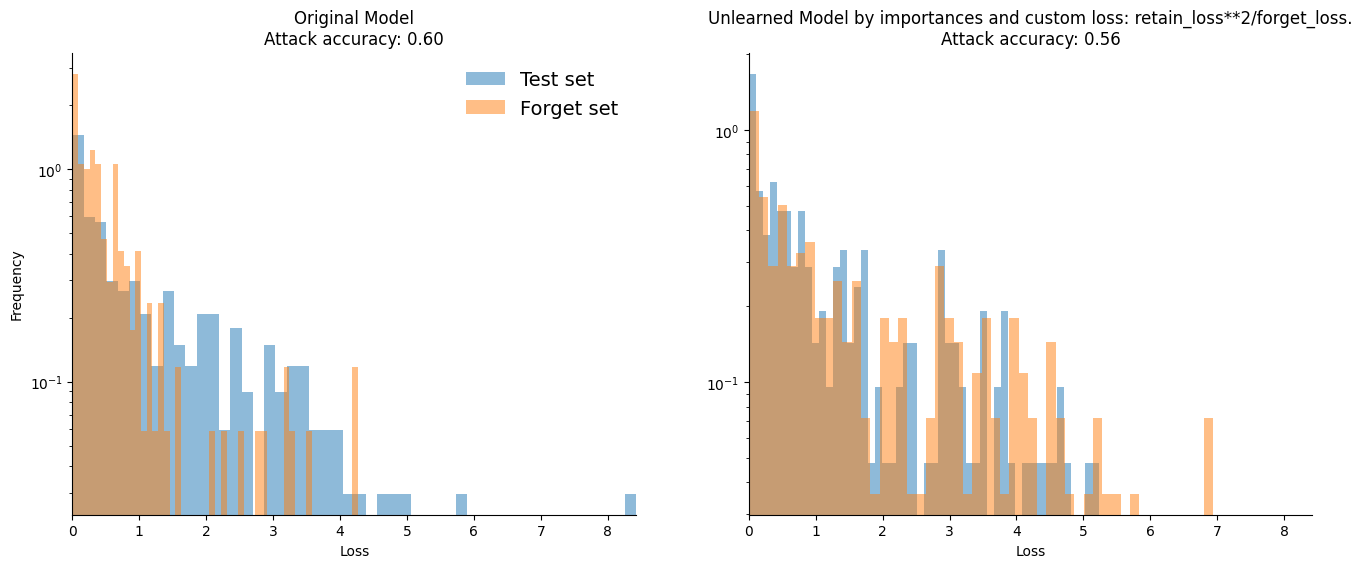

In [ ]:
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain_loss**2/forget_loss")

============ Metrics for Original Model ============
Train Accuracy: 78.0%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: retain_loss**2/forget_loss and specific scalings ============
Train Accuracy: 74.6%
Test Accuracy: 63.8%
MIA score: 0.5675

Final Score: 0.7513


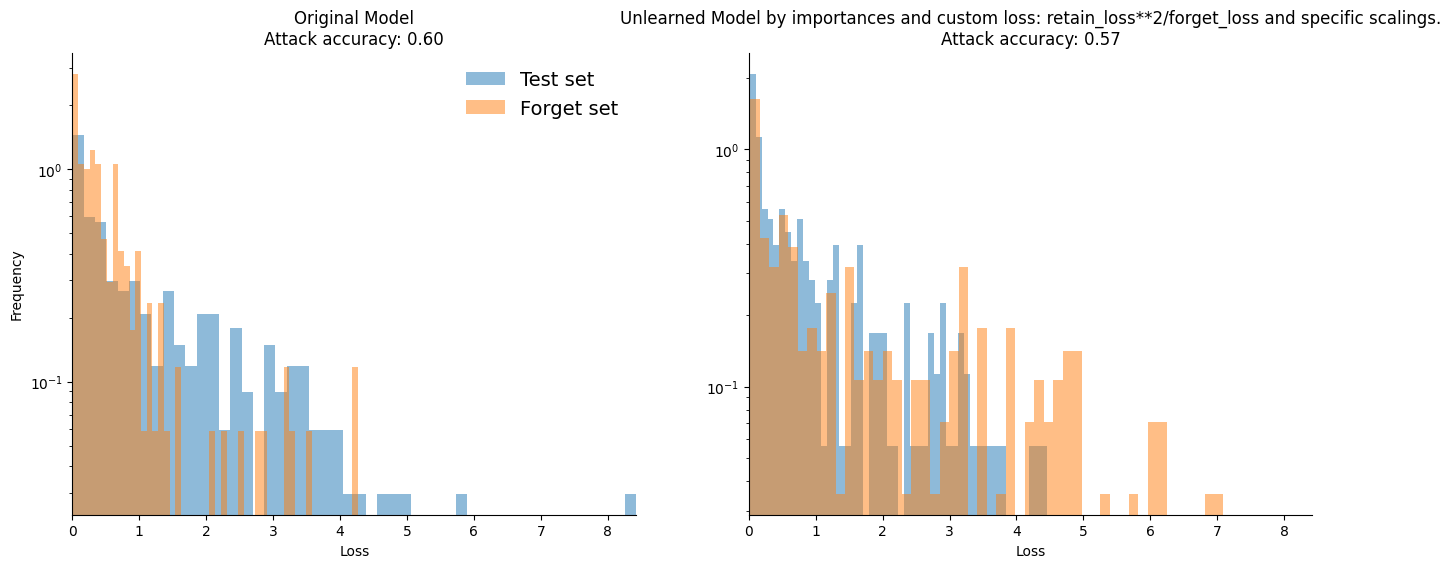

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: retain_loss**2/forget_loss and specific scalings")

============ Metrics for Original Model ============
Train Accuracy: 78.0%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss: scaling_factor*retain_loss**2/forget_loss ============
Train Accuracy: 74.2%
Test Accuracy: 58.6%
MIA score: 0.5525

Final Score: 0.7407


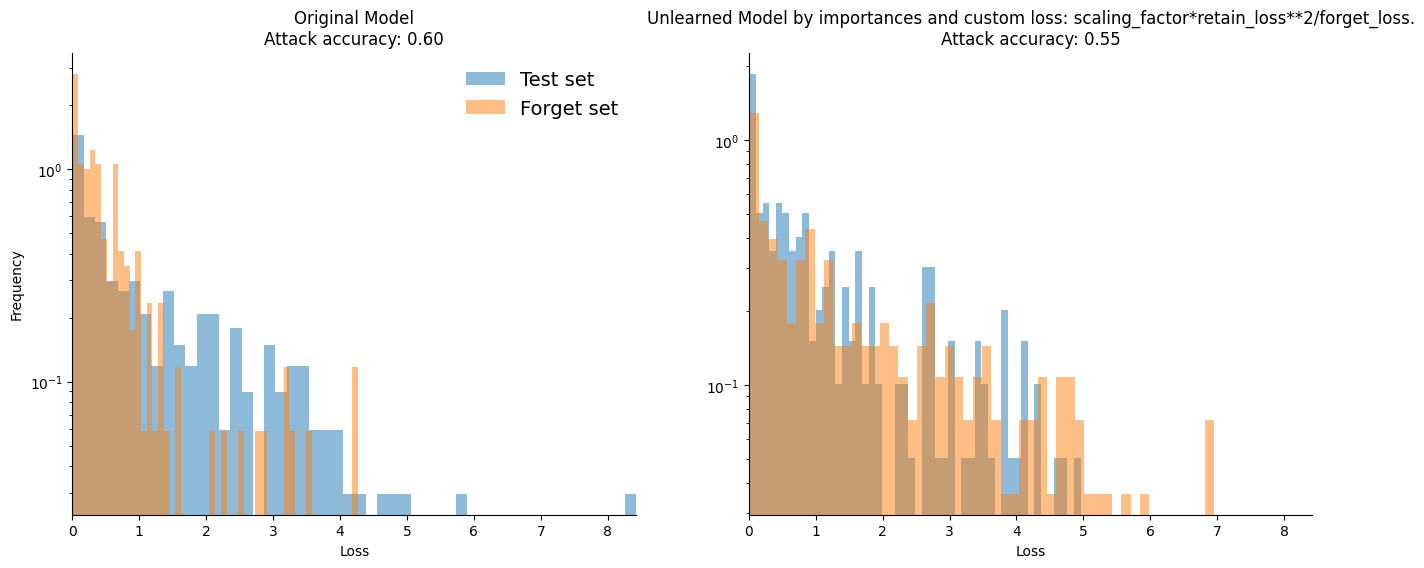

In [ ]:
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss: scaling_factor*retain_loss**2/forget_loss")

============ Metrics for Original Model ============
Train Accuracy: 78.0%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss (forget_weight = 0.25) ============
Train Accuracy: 74.5%
Test Accuracy: 59.8%
MIA score: 0.5825

Final Score: 0.7164


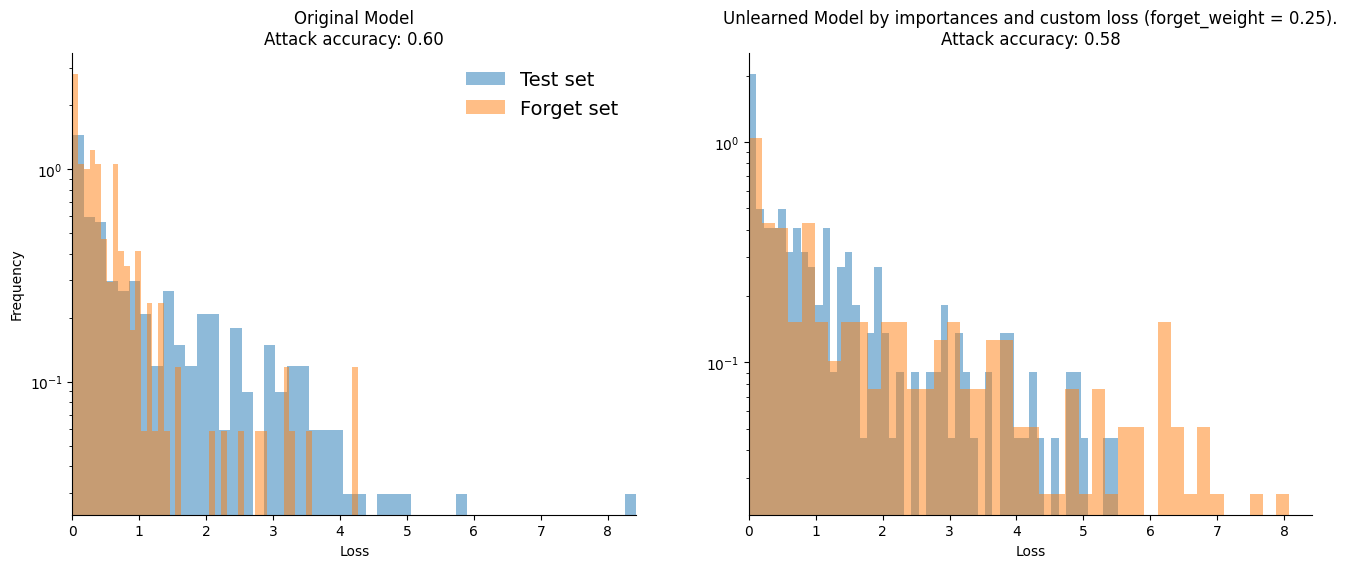

In [ ]:
orget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss (forget_weight = 0.25)")

============ Metrics for Original Model ============
Train Accuracy: 78.4%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.7002
============ Metrics for Unlearned Model by importances and custom loss (forget_weight = 0.1) ============
Train Accuracy: 78.4%
Test Accuracy: 61.2%
MIA score: 0.5575

Final Score: 0.7484


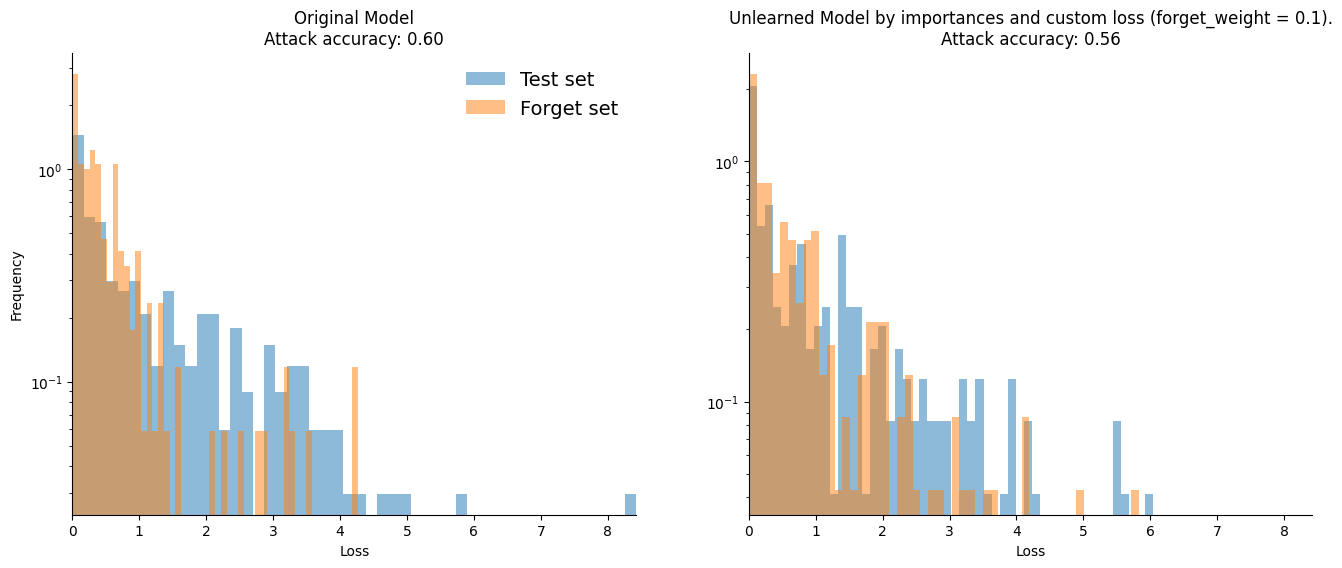

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by importances and custom loss (forget_weight = 0.1)")

In [ ]:
# forget_weight = 0.1
ret = score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader, original_model, retrained_model, unlearning_adaptive_ssd, 10)
ret

  0%|          | 0/10 [00:00<?, ?it/s]

{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 50}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 50}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 50}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 50}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_weighting': 50}
{'lower_bound': 1, 'exponent': 1, 'magnitude_diff': None, 'min_layer': -1, 'max_layer': -1, 'forget_threshold': 1, 'dampening_constant': 0.1, 'selection_we

  0%|          | 0/200 [00:00<?, ?it/s]

{'total_score': 0.08374212564427529,
 'F': 0.088909912109375,
 'unlearn_retain_accuracy': 0.7912977099236642,
 'unlearn_test_accuracy': 0.6388962765957447,
 'unlearn_forget_accuracy': 0.6505000000000001,
 'retrain_retain_accuracy': 0.8643256997455471,
 'retrain_test_accuracy': 0.6210106382978723,
 'retrain_forget_accuracy': 0.7,
 'retrain_outputs': array([[0.01530928, 0.50322309, 0.29145549, ..., 0.31703226, 0.28435204,
         0.08524441],
        [0.01715388, 0.51650507, 0.28202307, ..., 0.31692629, 0.2859708 ,
         0.08520762],
        [0.01716396, 0.51376142, 0.2828416 , ..., 0.33113059, 0.28912801,
         0.0866222 ],
        ...,
        [0.01661826, 0.49299493, 0.30268361, ..., 0.32597271, 0.27821758,
         0.08801026],
        [0.01645174, 0.5067687 , 0.27984988, ..., 0.3202327 , 0.28104661,
         0.08962292],
        [0.01668905, 0.50745514, 0.29675643, ..., 0.3244714 , 0.27484974,
         0.08793499]]),
 'unlearn_outputs': array([[0.4088987 , 0.2734919 , 0.16807

## **Approach 5: Student-teacher framework**
* uses a student-teacher framework to induce forgetfulness
* the knowledge from competent and incompetent teachers is selectively transfered to a student to obtain a model that doesn't contain any information about forget data.

In [ ]:
def unlearning_student(net, retain_loader, forget_loader, val_loader, DEVICE, unfreezed_layers):
    # to be included
    net.eval()
    return net

In [ ]:
unlearned_model = copy.deepcopy(original_model)
unlearned_model = unlearning_student(unlearned_model, retain_loader, forget_loader, val_loader, DEVICE)

In [ ]:
compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Student Teacher Approach")

In [ ]:
ret = score_unlearning_algorithm(retain_loader, forget_loader, val_loader, test_loader, original_model, retrained_model, unlearning_student, 10)
ret

## **Approach 6: Fine-tuning with freezed layers**



In [ ]:
def unlearning_freezed(net, retain_loader, forget_loader, val_loader, DEVICE, unfreezed_layers):
    """Unlearning by fine-tuning with freezing.

    Fine-tuning is a very simple algorithm that trains using only
    the retain set.

    Args:
      net : nn.Module.
        pre-trained model to use as base of unlearning.
      retain_loader : torch.utils.data.DataLoader.
        Dataset loader for access to the retain set. This is the subset
        of the training set that we don't want to forget.
      forget_loader : torch.utils.data.DataLoader.
        Dataset loader for access to the forget set. This is the subset
        of the training set that we want to forget. This method doesn't
        make use of the forget set.
      val_loader : torch.utils.data.DataLoader.
        Dataset loader for access to the validation set. This method doesn't
        make use of the validation set.
    Returns:
      net : updated model
    """
    # Freeze all layers in the model
    for param in net.parameters():
        param.requires_grad = False

    # Unfreeze the specified layers (for example, the last 2 layers)
    # Note: ResNet18 features layers are named 'layer1', 'layer2', 'layer3', 'layer4'
    for name, child in net.named_children():
        if name in unfreezed_layers:
            for param in child.parameters():
                param.requires_grad = True

    epochs = 1

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, net.parameters()), lr=0.001, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    net.train()

    for _ in range(epochs):
        for inputs, targets in retain_loader:
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
        scheduler.step()

    net.eval()
    return net

In [ ]:
unlearned_model = copy.deepcopy(original_model)
unlearned_model = unlearning_freezed(unlearned_model, retain_loader, forget_loader, val_loader, DEVICE, ['layer4'])

============ Metrics for Original Model ============
Train Accuracy: 78.2%
Test Accuracy: 61.0%
MIA score: 0.6050

Final Score: 0.6999
============ Metrics for Unlearned Model by Fine-tuning ============
Train Accuracy: 81.2%
Test Accuracy: 65.4%
MIA score: 0.6100

Final Score: 0.7171


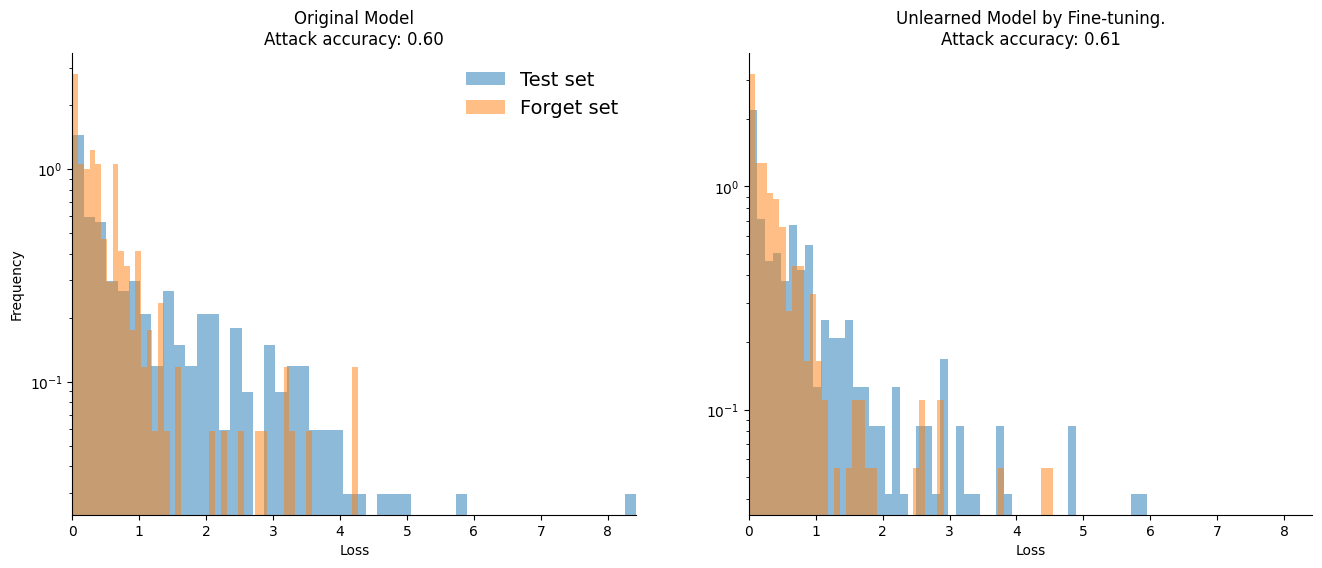

In [ ]:
forget_score, retain_accuracy, test_accuracy = compare_models(original_model, unlearned_model, retain_loader, forget_loader, test_loader, DEVICE, "Original Model", model2_name="Unlearned Model by Fine-tuning")